In [1]:
## This notebook contains the analysis of clustering data from the five GI maps in this study as well as plots that are designed to aid in 
## the readers ability to interpret our data 

## plots generated using this notebook are used in Figures 3A, 3C, 7A-H, S7H

## This notebook requries the "circos" conda environment

In [4]:
## Import packages

import seaborn as sns
from seaborn import clustermap
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
from scipy.stats import gaussian_kde
import networkx as nx
import requests
import pycirclize
import colorsys

In [5]:
################ Define functions here ################

##Import Max's handy upperTriangle function to avoid counting AB BA GIs twice
def upperTriangle(matrix, k=1):
    keep = np.triu(np.ones(matrix.shape), k=k).astype('bool').reshape(matrix.size)
    return matrix.stack(future_stack=True).loc[keep]

## The function "deconstruct_tree"  will take an integer value representing the highest node of a hierarchical
## clustering and a distance matrix for that clustering. An empty list "branch_identity" must be defined first. 
def deconstruct_tree(start,tree):
    node = tree[start]
    if node[0] > len(tree):
        deconstruct_tree(int(node[0]-(len(tree)+1)),tree)
    if node[0] <= len(tree):
        branch_identity.append(node[0])
    if node[1] > len(tree):
        deconstruct_tree(int(node[1]-(len(tree)+1)),tree)
    if node[1] <= len(tree):
        branch_identity.append(node[1])


## Define a function that takes an Enrichr enrichment result and a significance threshold and returns a DataFrame 
## containing significant go-terms and their associated -log10 adjusted p-values over a certain threshold
def enrichDf(result,sig):
    result['Adjusted P-value'] = -np.log10(result['P-value'])
    termList =[]
    scoreList = []
    for go in result.loc[result['Adjusted P-value'] > sig]['Term']:
        goterm = go.split(' (')[0]
        termList.append(goterm)
    for score in result.loc[result['Adjusted P-value'] > sig]['Adjusted P-value']:
        scoreList.append(score)
    outDf = pd.DataFrame(index=termList)
    outDf['Score'] = scoreList
    return outDf

## Here I would like to iterate through every cluster and return a matrix with index equal to all the
## genes in the map, and columns equal to every cluster, with bools filled in to represent if that gene belongs to 
## that cluster
def make_cluster_matrix(gimap,distance_matrix):
    out_matrix = pd.DataFrame(index = gimap.index, columns = range(len(gimap.index)-1))
    for cluster in out_matrix.columns:
        branch_identity = []
        deconstruct_tree(cluster,distance_matrix)
        branch_names = gimap.iloc[branch_identity].index
        print(branch_identity)
        for gene in out_matrix.index:
            if gene in branch_names:
                out_matrix.loc[gene,cluster] = True
            else:
                out_matrix.loc[gene,cluster] = False
    return out_matrix

## annotate_tree will be used to fully annotate each map with clusters from a list of shared cluster between maps. It
## will take an empty input DataFrame with index equal to the unclustered GI map index, the GI map index itself, the 
## shared list, the GI cluster matrix, "layer" which should always be 0, "go_terms_analyzed", which should always be 
## an empty list and a dictionary where cluster identities are keys and values are color codes. Outputs a DataFrame 
## with index equal to the unclustered map index and columns equal to the number of layers of overlapping GO term
## annotated clusters. 

def annotation_tree(annotate_df, map_index, shared_list, cluster_matrix,layer,paired_dict):    
    layer = 0
    go_terms_analyzed = []
    total_gene_list = list(map_index)
    in_layer = pd.DataFrame(index = range(len(map_index)),columns =['fill'])
    in_layer = list(in_layer['fill'])
    for cluster in shared_list:
        if cluster in go_terms_analyzed:
            continue
        gene_list = list(cluster_matrix.loc[cluster_matrix[cluster]==True].index)
        if all_shared(gene_list,total_gene_list):
            for i,gene in enumerate(annotate_df.index):
                if gene in gene_list:
                    if cluster in paired_dict.keys():
                        in_layer[i] = paired_dict[cluster]
                        #in_layer[i] = 'lightcoral'
                    else:
                        in_layer[i] = 'black'
            total_gene_list = [item for item in total_gene_list if item not in gene_list]
            go_terms_analyzed.append(cluster)
    annotate_df[layer] = in_layer
    layer += 1 
    if all_shared(list(shared_list),go_terms_analyzed) == False:
        annotation_tree(annotate_df,map_index,shared_list,cluster_matrix,layer,go_terms_analyzed,paired_dict)
    return annotate_df
 
## cluster_thresh will take a distance matrix a distance threshold and return a list of the largest clusters that are
## generated under that threshold. Output will list clusters drawn as max_number_elements+cluster_number, in this case
## max_number_elements is 302
def cluster_thresh(distance_matrix,distance_thresh):
    out_list = []
    for i,branch in enumerate(distance_matrix):
        if branch[2] > distance_thresh:
            break 
        if branch[0] in out_list:
            out_list.remove(branch[0])
        if branch[1] in out_list:
            out_list.remove(branch[1])
        out_list.append(i+303)
    return out_list
    
## make_ont_map takes a list of ontology name "o_list", a list of cluster identities associated with those ontologies
## "o_cluster_list", a matrix of GI scores "gi_map", and a cluster matrix for the hierarchical clustering and returns
## a matrix of the absolute average GI scores between all genes in each pair of ontologies within the map
def make_ont_map(o_list,o_cluster_list,gi_map,cluster_matrix):
    out_map = pd.DataFrame(index = o_list, columns = o_list)
    std_map = pd.DataFrame(index = o_list, columns = o_list)
    for i in range(len(out_map.index)):
        gl1 = list(consensus_cluster_matrix.loc[cluster_matrix[o_cluster_list[i]]==True].index)
        for j in range(len(out_map.columns)):
            gl2 = list(consensus_cluster_matrix.loc[cluster_matrix[o_cluster_list[j]]==True].index)
            out_map.iloc[i,j] = float(gi_map.loc[gl1,gl2].values.mean())
            std_map.iloc[i,j] = float(gi_map.loc[gl1,gl2].values.std())    
    return out_map,std_map

    
## make_nx_graph takes an ont_map as returned by the function "make_ont_map"
def make_nx_graph(ont_map,adjust,thresh):
    out_graph = nx.Graph()
    for ont1 in ont_map.index:
        for ont2 in ont_map.columns:
            if ont1 == ont2:
                continue
            if ont1 not in out_graph.nodes:
                out_graph.add_node(ont1,color='dimgray')
            if ont2 not in out_graph.nodes:
                out_graph.add_node(ont2,color='dimgray') 
            if abs(ont_map.loc[ont1,ont2]) > thresh:
                out_graph.add_node(ont1,color = ont_color_key[ont1])
                out_graph.add_node(ont2,color = ont_color_key[ont2])
                out_graph.add_edge(ont1,ont2,weight = (abs(ont_map.loc[ont1,ont2]**2)/adjust),color='lightcoral')    
            if abs(ont_map.loc[ont1,ont2]) < thresh:
                out_graph.add_edge(ont1,ont2,weight = (abs(ont_map.loc[ont1,ont2])/adjust),color='dimgray')
    plt.figure(figsize=(5,5))   
    plt.axis('off')
    nx.draw_networkx(out_graph,
        pos = nx.circular_layout(out_graph),
        node_color = [item[1] for item in out_graph.nodes.data('color')],
        edge_color = [item[2] for item in out_graph.edges.data('color')],
        node_size = 200,
        width = [item[2] for item in out_graph.edges.data('weight')],
        with_labels = False
                )

## make_col_df will take a gene list that is the index of a GI map, and, given a "consensus_annotations" DF, and a 
## "ont_color_key" dictionary, will return a df of index equal to the gene list and a color "Color" with the associated
## color relating to a GO term enriched cluster present in the data
def make_col_df(gene_list):
    out_df = pd.DataFrame(index = gene_list,columns = ['Color'])
    for gene in gene_list:
        for i in consensus_annotations.index:
            if gene in consensus_annotations.loc[i,'Genes']:
                term = consensus_annotations.loc[i,"Term"]
                if term != 'none':
                    out_df.loc[gene,'Color'] = ont_color_key[term]
    out_df = out_df.fillna('dimgray')   
    return out_df

def make_ont_col_df(gene_list,target_list):
    out_df = pd.DataFrame(index = gene_list,columns = ['Color'])
    for gene in gene_list:
        for i in consensus_annotations.index:
            if gene in consensus_annotations.loc[i,'Genes']:
                term = consensus_annotations.loc[i,"Term"]
                if term in target_list:
                    out_df.loc[gene,'Color'] = ont_color_key[term]           
    out_df = out_df.fillna('dimgray')   
    return out_df

def make_gene_col_df(gene_list,target_list):
    #c_temp = sns.color_palette("husl",len(target_list))
    out_df = pd.DataFrame(index = gene_list, columns = ['Color'])
    for i, gene in enumerate(target_list):
        out_df.loc[gene,'Color'] = 'lightcoral'
    out_df = out_df.fillna('dimgray')    
    return out_df

## split_map will take two gi maps adn return a matrix in which map1 occupies the lower triangle of the matrix and
## map2 occupies the upper triangle. Along the diagonal input 0
def split_map(map1,map2):
    if all(map1.index != map2.index):
        print('the indices are not the same!')
    out_map = pd.DataFrame(index = map1.index,columns = map1.columns)
    for i in range(len(map1.index)):
        for n in range(len(map1.index)):
            if i == n:
                out_map.iloc[i,n] = np.nan
            if i > n:
                out_map.iloc[i,n] = float(map1.iloc[i,n])
            if i < n:
                out_map.iloc[i,n] = float(map2.iloc[i,n])
    return out_map

## gimap_circos takes one eGI or GI matrix, a threshold to decided how strong the GI score between two ontologies need to be to consider them
## significant, and a bool to decide whether to plot text. It returns a circos plots of all consensus ontologies defined in 
## "consensus_annotations" with blue edge drawn if they have a significant negative interaction score between them and a yellow edge drawn if
## there is a significant positive interaction score between them. 
def gimap_circos(gimap, ont_thresh, text_yn):
    circos = pycirclize.Circos(ont_dict, space=2)
    for sector in circos.sectors:
        track = sector.add_track((90, 100))
        track.axis(fc='dimgray')
        #track.xticks_by_interval(1,label_orientation="vertical")
        #sector.text(sector.name, r=105, size=10,facing = "outside")
    for i in range(len(consensus_annotations['Term'])):
        t1 = consensus_annotations.loc[i,'Term']
        gl1= consensus_annotations.loc[i,'Genes']
        for j in range(i+1,len(consensus_annotations['Term'])):
            t2 = consensus_annotations.loc[j,'Term']
            gl2= consensus_annotations.loc[j,'Genes']
            if gimap.loc[gl1,gl2].values.mean() > ont_thresh:
                circos.link((t1, 0, 1), (t2, 1, 0),color='gold')
                circos.tracks[i].axis(fc = ont_color_key[t1])
                circos.tracks[j].axis(fc = ont_color_key[t2])
                if text_yn == True:
                    circos.sectors[i].text(circos.sectors[i].name,r=105,size=8)
                    circos.sectors[j].text(circos.sectors[j].name,r=105,size=8)
            if gimap.loc[gl1,gl2].values.mean() < -ont_thresh:
                circos.link((t1, 0, 1), (t2, 1, 0),color='mediumturquoise')
                circos.tracks[i].axis(fc = ont_color_key[t1])
                circos.tracks[j].axis(fc = ont_color_key[t2])
                if text_yn == True:
                    circos.sectors[i].text(circos.sectors[i].name,r=105,size=8)
                    circos.sectors[j].text(circos.sectors[j].name,r=105,size=8)
    fig = circos.plotfig()

## gimap_di_circos takes three GI matrices, a dGI map, eGI map, and reference GI map, a threshold to decided how strong the dGI scores
## between two ontologies need to be to consider them significant, and a bool to decide whether to plot text. It returns a circos plots of 
## all consensus ontologies defined in "consensus_annotations" with pink edge drawn if they have a significant interaction score between them
## in the dGI and eGI matrix but not in the GI matrix (new interaction) and a gray edge drawn if there is a significant interaction
## in the dGI and GI matrix but not in the eGI matrix (lost interaction).
def gimap_di_circos(dgimap, egimap, gimap, ont_thresh, text_yn):
    circos = pycirclize.Circos(ont_dict, space=2)
    for sector in circos.sectors:
        track = sector.add_track((90, 100))
        track.axis(fc='dimgray')
    for i in range(len(consensus_annotations['Term'])):
        t1 = consensus_annotations.loc[i,'Term']
        gl1= consensus_annotations.loc[i,'Genes']
        for j in range(i+1,len(consensus_annotations['Term'])):
            t2 = consensus_annotations.loc[j,'Term']
            gl2= consensus_annotations.loc[j,'Genes']
            if abs(dgimap.loc[gl1,gl2].values.mean()) > ont_thresh:
                if abs(egimap.loc[gl1,gl2].values.mean()) > ont_thresh:
                    if abs(gimap.loc[gl1,gl2].values.mean()) < ont_thresh:
                        circos.link((t1, 0, 1), (t2, 1, 0),color='lightcoral')
                        circos.tracks[i].axis(fc = ont_color_key[t1])
                        circos.tracks[j].axis(fc = ont_color_key[t2])
                if abs(egimap.loc[gl1,gl2].values.mean()) < ont_thresh:
                    if abs(gimap.loc[gl1,gl2].values.mean()) > ont_thresh:
                        circos.link((t1, 0, 1), (t2, 1, 0),color='dimgray')
                        circos.tracks[i].axis(fc = ont_color_key[t1])
                        circos.tracks[j].axis(fc = ont_color_key[t2])
                if text_yn == True:
                    circos.sectors[i].text(circos.sectors[i].name,r=105,size=8)
                    circos.sectors[j].text(circos.sectors[j].name,r=105,size=8)
    fig = circos.plotfig()


## col_map_maker takes a list of absolute value correlation values (must be 0-1) of length 44 and returns a list of equivalent size filled 
## with colors. These relate to the correlation between a given cluster and every other cluster in a given condition. The colors are picked
## using the ont_color_key dataframe so that highly (close to 1) correlated clusters are a more vibrant hue, while uncorrelated clusters 
## appear in greyscale
def col_map_maker(vals):
    col_list = []
    for i in range(44):
        palette = sns.blend_palette(['dimgray',list(ont_color_key.values())[i]], as_cmap=True)
        col_list.append(palette(vals[i]))
    return(col_list)

## corr_scatter will take a conserved cluster index number (0-43) and returns a stacked scatter plot showing the ontology level correlations
## between the chosen cluster and every other cluster in this study for the first reference map and all environmental maps in this study 
def corr_scatter(ind):
    scale_factor = 200
    vmin = -0.5
    vmax = 0.5
    int_list_1 = []
    int_list_2 = []
    int_list_3 = []
    int_list_4 = []
    for i in range(len(dmso1_corr_ont.index)):
        int_list_1.append(7+dmso1_corr_ont.iloc[ind,i])
        int_list_2.append(5+atr_corr_ont.iloc[ind,i])
        int_list_3.append(3+etop_corr_ont.iloc[ind,i])
        int_list_4.append(1+keto_corr_ont.iloc[ind,i])
    for i in range(0,45,5):
        plt.plot((i,i),(0,10),':',color = 'dimgray',alpha=0.7)
    for i in range(1,10,2):
        plt.plot((-1,44),(i,i),color = 'black')
    for i in range(0,9,2):
        plt.plot((-1,44),(i,i),color = 'black',linewidth = 1.0)
    #plt.scatter([ind for i in range(4)],range(1,8,2),s=20,color ='red')
    plt.plot((ind,ind),(0,8),color ='red')
    plt.scatter(range(len(dmso1_corr_ont.index)),
               int_list_1,
               s = list(abs(dmso1_corr_ont.iloc[ind,:]*scale_factor)),
                linewidths=0.5,
               edgecolor='black',
                #vmin = -dmso1_corr_ont.iloc[ind,:].max(), vmax = dmso1_corr_ont.iloc[ind,:].max(),
               c = col_map_maker(abs(dmso1_corr_ont.iloc[ind,:])))
    
    plt.scatter(range(len(atr_corr_ont.index)),
               int_list_2,
               s = list(abs(atr_corr_ont.iloc[ind,:]*scale_factor)),
                linewidths=0.5,
               edgecolor='black',
                #vmin = -atr_corr_ont.iloc[ind,:].max(), vmax = atr_corr_ont.iloc[ind,:].max(),
               c = col_map_maker(abs(atr_corr_ont.iloc[ind,:])))
    
    plt.scatter(range(len(etop_corr_ont.index)),
               int_list_3,
               s = list(abs(etop_corr_ont.iloc[ind,:]*scale_factor)),
                linewidths=0.5,
               edgecolor='black',
                #vmin = -etop_corr_ont.iloc[ind,:].max(), vmax = etop_corr_ont.iloc[ind,:].max(),
               c = col_map_maker(abs(etop_corr_ont.iloc[ind,:])))
    
    plt.scatter(range(len(keto_corr_ont.index)),
               int_list_4,
               s = list(abs(keto_corr_ont.iloc[ind,:]*scale_factor)),
                linewidths=0.5,
               edgecolor='black',
                #vmin = -keto_corr_ont.iloc[ind,:].max(), vmax = keto_corr_ont.iloc[ind,:].max(),
               c = col_map_maker(abs(keto_corr_ont.iloc[ind,:])))

    plt.ylim(0,8)
    plt.xlim(-1,44)
    plt.xticks([])
    plt.yticks([])

In [6]:
## A color map from Max Horlbeck in his 14.33 notebook for drawing GI heatmaps in the traditional blue/yellow scheme

cdict = {'red':((0.0,0.125,0.125),
                (0.5,0.0,0.0),
                (1.0,0.957,0.957)),
        'green':((0.0,0.713,0.713),
                (0.5,0.0,0.0),
                (1.0,0.918,0.918)),
        'blue': ((0.0,0.886,0.886),
                (0.5,0.0,0.0),
                (1.0,0.094,0.094))}
blue_yellow = matplotlib.colors.LinearSegmentedColormap('BlueYellow',cdict)
blue_yellow.set_bad('w')

matplotlib.colormaps.register(cmap=blue_yellow)

In [7]:
## Import data

## gene level maps as generated by "generateGeneMap" function in "call_genetic_interactions" notebook
dmso1_map = pd.read_excel('/Users/benh/Desktop/GI_data/gene_maps/dmso1_map.xlsx',index_col = 0)
atr_map = pd.read_excel('/Users/benh/Desktop/GI_data/gene_maps/atr_map.xlsx',index_col = 0)
dmso2_map = pd.read_excel('/Users/benh/Desktop/GI_data/gene_maps/dmso2_map.xlsx',index_col = 0)
etop_map = pd.read_excel('/Users/benh/Desktop/GI_data/gene_maps/etop_map.xlsx',index_col = 0)
keto_map = pd.read_excel('/Users/benh/Desktop/GI_data/gene_maps/keto_map.xlsx',index_col = 0)
dmso1_map = dmso1_map.fillna(0)
atr_map = atr_map.fillna(0)
dmso2_map = dmso2_map.fillna(0)
etop_map = etop_map.fillna(0)
keto_map = keto_map.fillna(0)

## sgRNA level maps as generated by "calculateInteractions" function in "call_genetic_interactions" notebook
dmso1_sgmap = pd.read_excel('/Users/benh/Desktop/GI_data/guide_maps/dmso1_sgmap.xlsx',index_col = 0)
dmso2_sgmap = pd.read_excel('/Users/benh/Desktop/GI_data/guide_maps/dmso2_sgmap.xlsx',index_col = 0)
atr_sgmap = pd.read_excel('/Users/benh/Desktop/GI_data/guide_maps/atr_sgmap.xlsx',index_col = 0)
etop_sgmap = pd.read_excel('/Users/benh/Desktop/GI_data/guide_maps/etop_sgmap.xlsx',index_col = 0)
keto_sgmap = pd.read_excel('/Users/benh/Desktop/GI_data/guide_maps/keto_sgmap.xlsx',index_col = 0)

## a single table to map sgRNAs to genes
singles_table = pd.read_excel('/Users/benh/Desktop/GI_data/singles_tables/singles_table.xlsx',index_col = 0)

In [8]:
## Remove 'non-targeting' from GI matrices

dmso1_map = dmso1_map.loc[dmso1_map.index != 'non-targeting',dmso1_map.index != 'non-targeting']
atr_map = atr_map.loc[atr_map.index != 'non-targeting',atr_map.index != 'non-targeting']
dmso2_map = dmso2_map.loc[dmso2_map.index != 'non-targeting',dmso2_map.index != 'non-targeting']
etop_map = etop_map.loc[etop_map.index != 'non-targeting',etop_map.index != 'non-targeting']
keto_map = keto_map.loc[keto_map.index != 'non-targeting',keto_map.index != 'non-targeting']

In [9]:
## turn sgrna matrices into gene-ntc matrices

dmso1_genentc = dmso1_sgmap.loc[singles_table['gene']!='non-targeting',singles_table['gene']=='non-targeting'].groupby(singles_table['gene']).mean().loc[dmso1_map.index,:]
dmso2_genentc = dmso2_sgmap.loc[singles_table['gene']!='non-targeting',singles_table['gene']=='non-targeting'].groupby(singles_table['gene']).mean().loc[dmso1_map.index,:]
atr_genentc = atr_sgmap.loc[singles_table['gene']!='non-targeting',singles_table['gene']=='non-targeting'].groupby(singles_table['gene']).mean().loc[dmso1_map.index,:]
etop_genentc = etop_sgmap.loc[singles_table['gene']!='non-targeting',singles_table['gene']=='non-targeting'].groupby(singles_table['gene']).mean().loc[dmso1_map.index,:]
keto_genentc = keto_sgmap.loc[singles_table['gene']!='non-targeting',singles_table['gene']=='non-targeting'].groupby(singles_table['gene']).mean().loc[dmso1_map.index,:]


In [10]:
## Make difference maps

dmso_di_map = dmso1_map - dmso2_map
etop_di_map = etop_map - dmso2_map
keto_di_map = keto_map - dmso2_map
atr_di_map = atr_map - dmso1_map


## A color map for the difference maps
diffColors = sns.diverging_palette(139,288,s= 63, l=64, center="dark", as_cmap=True)


In [11]:
## Make a consensus map by first normalizing all individual maps, then concatenating along one axis

dmso1_norm = dmso1_map/upperTriangle(dmso1_map).values.std()
atr_norm = atr_map/upperTriangle(atr_map).values.std()
dmso2_norm = dmso2_map/upperTriangle(dmso2_map).values.std()
etop_norm = etop_map/upperTriangle(etop_map).values.std()
keto_norm = keto_map/upperTriangle(keto_map).values.std()

concat_map = pd.concat((dmso2_norm,etop_norm,keto_norm,dmso1_norm,atr_norm),axis=1)

/opt/anaconda3/envs/circos/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/circos/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/circos/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/circos/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/circos/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warn

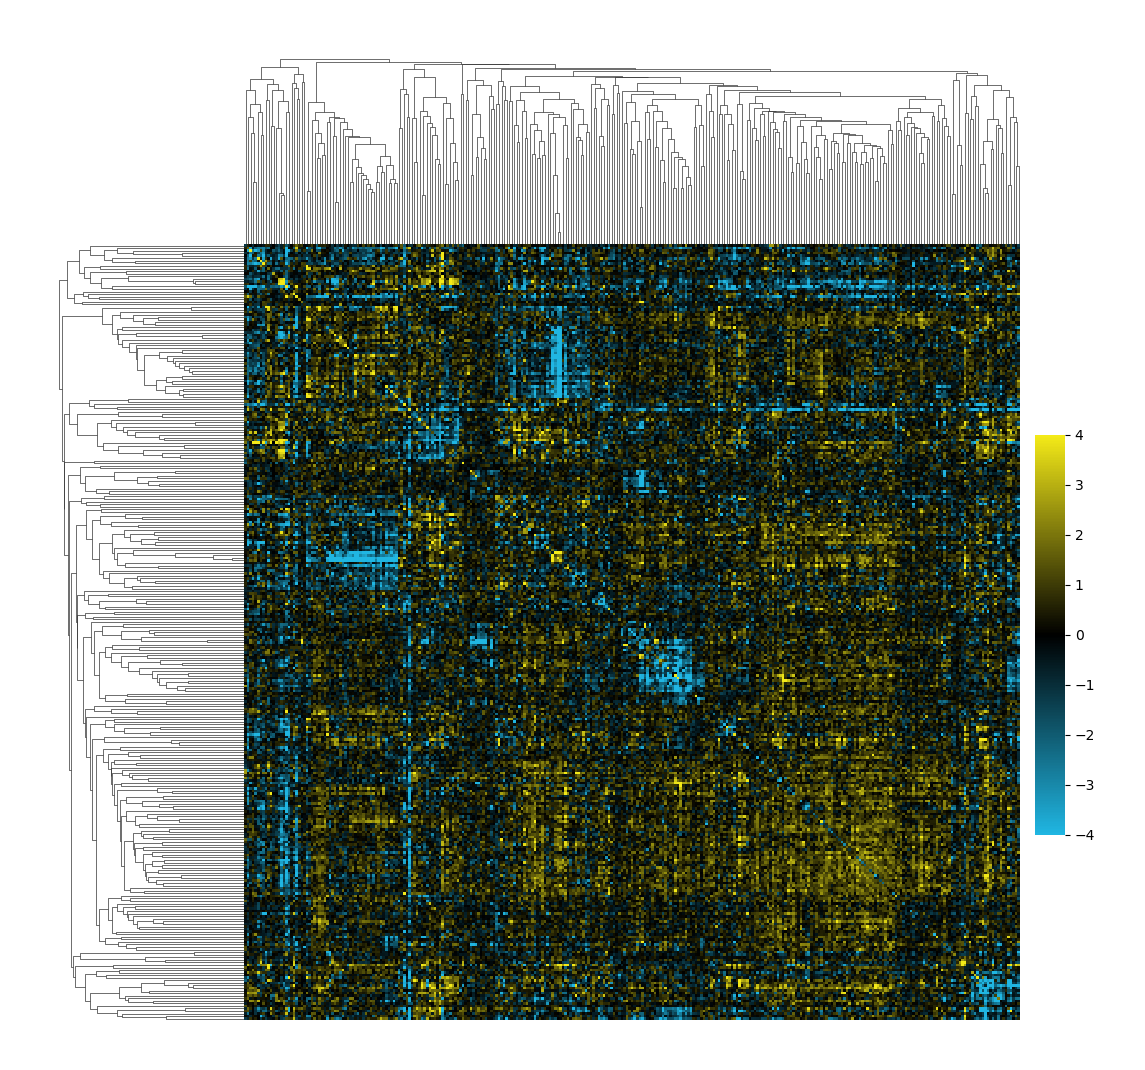

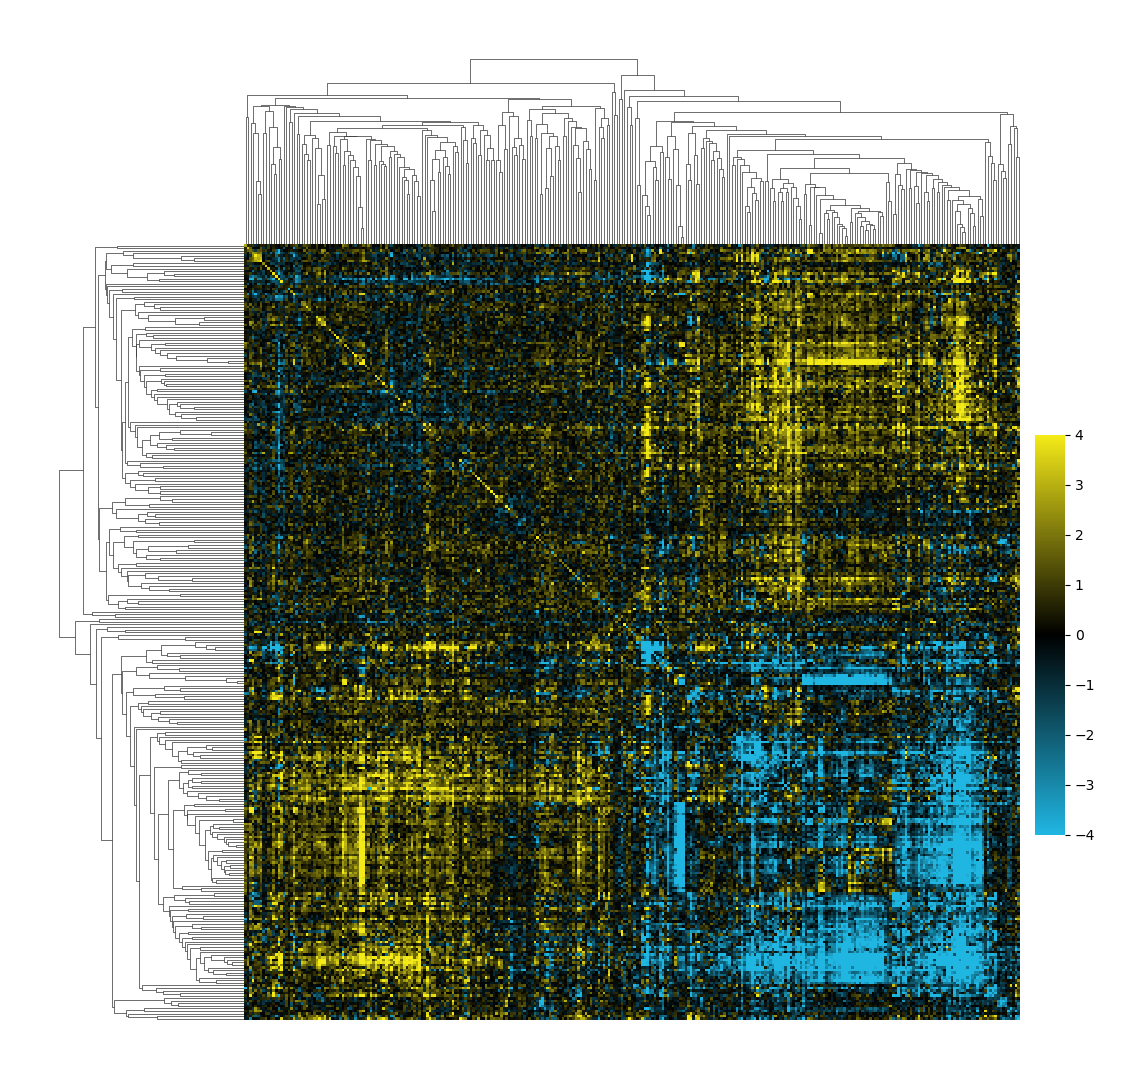

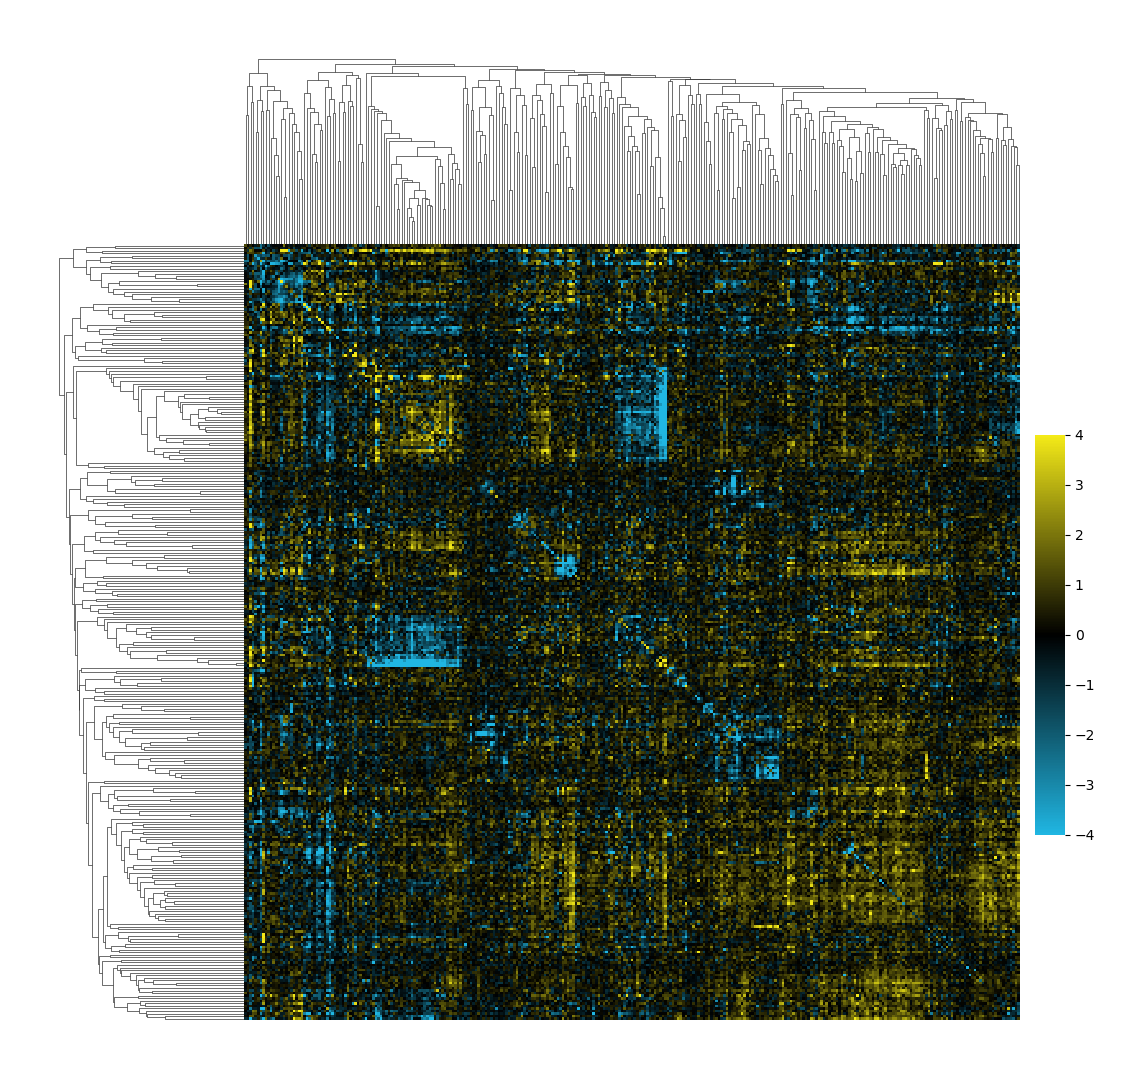

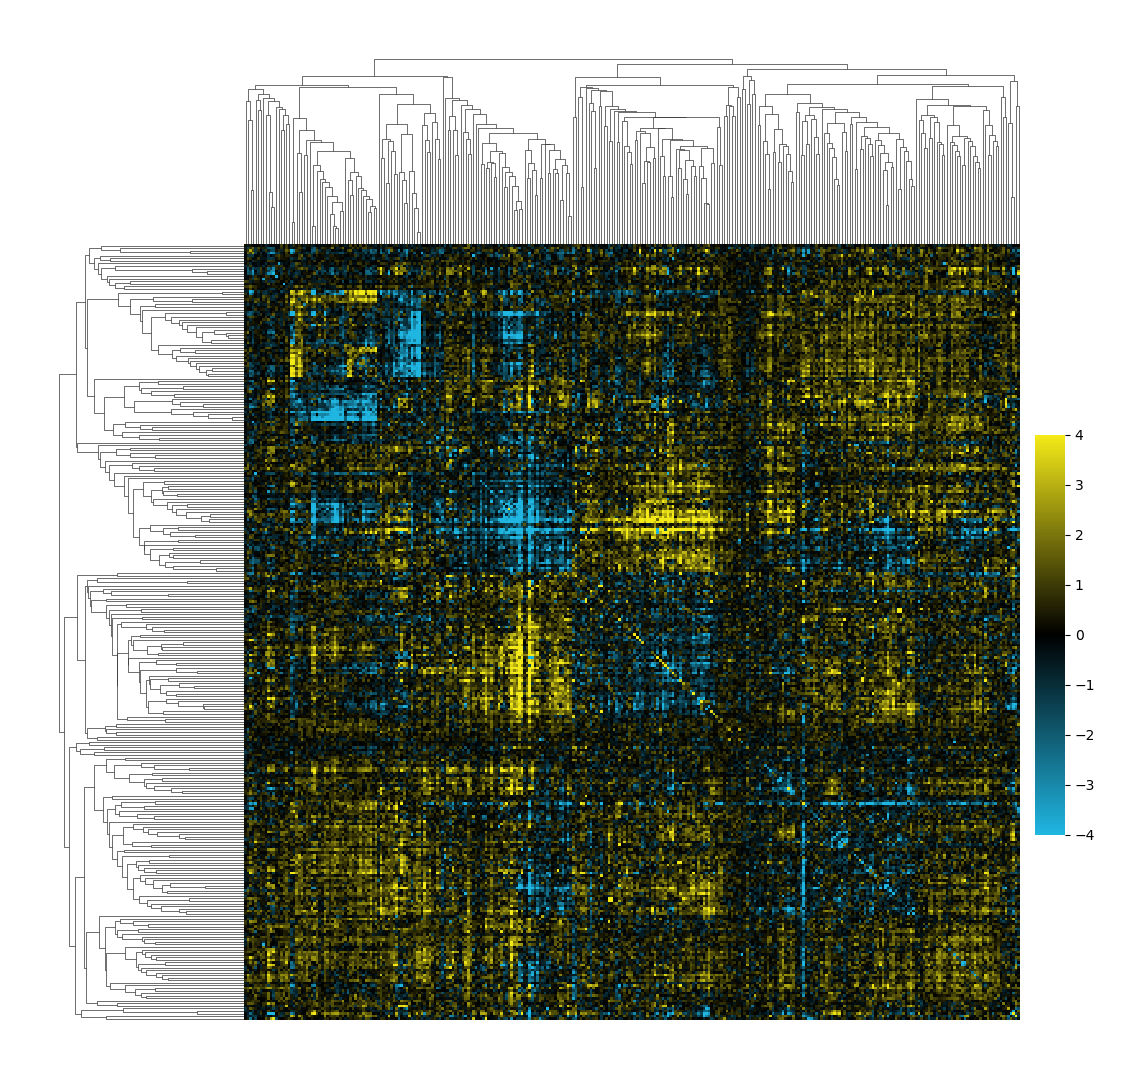

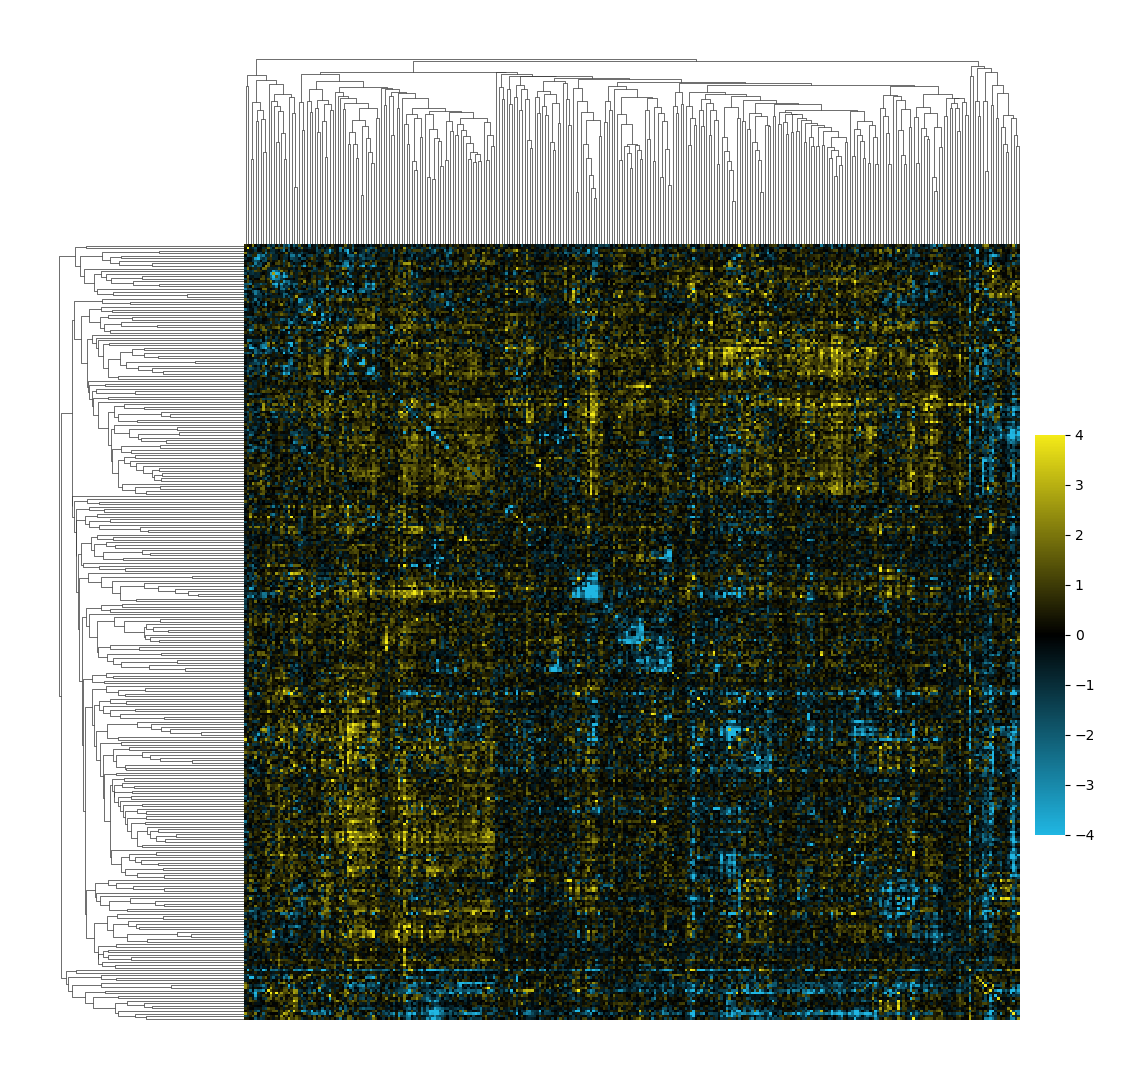

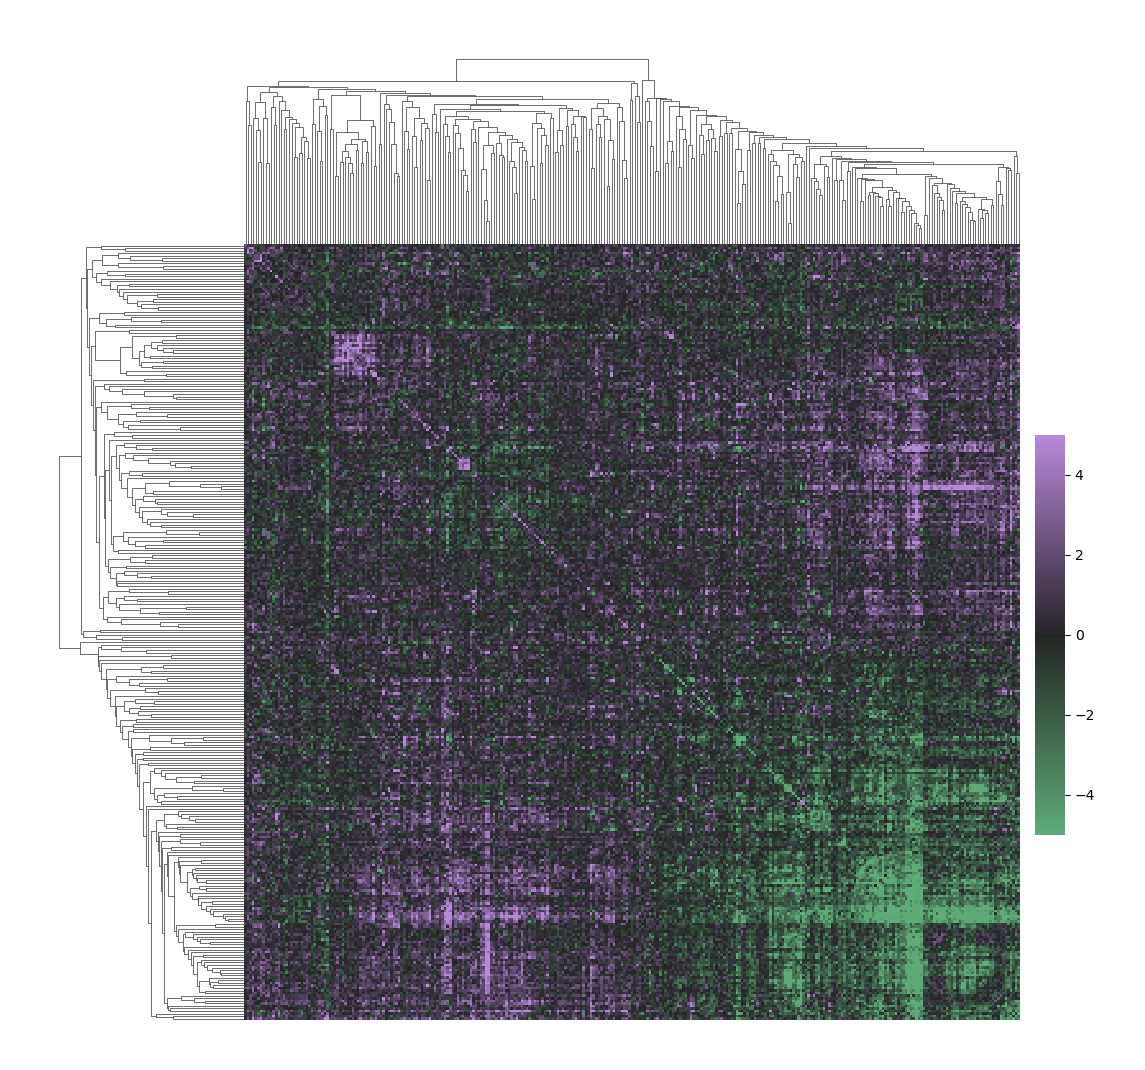

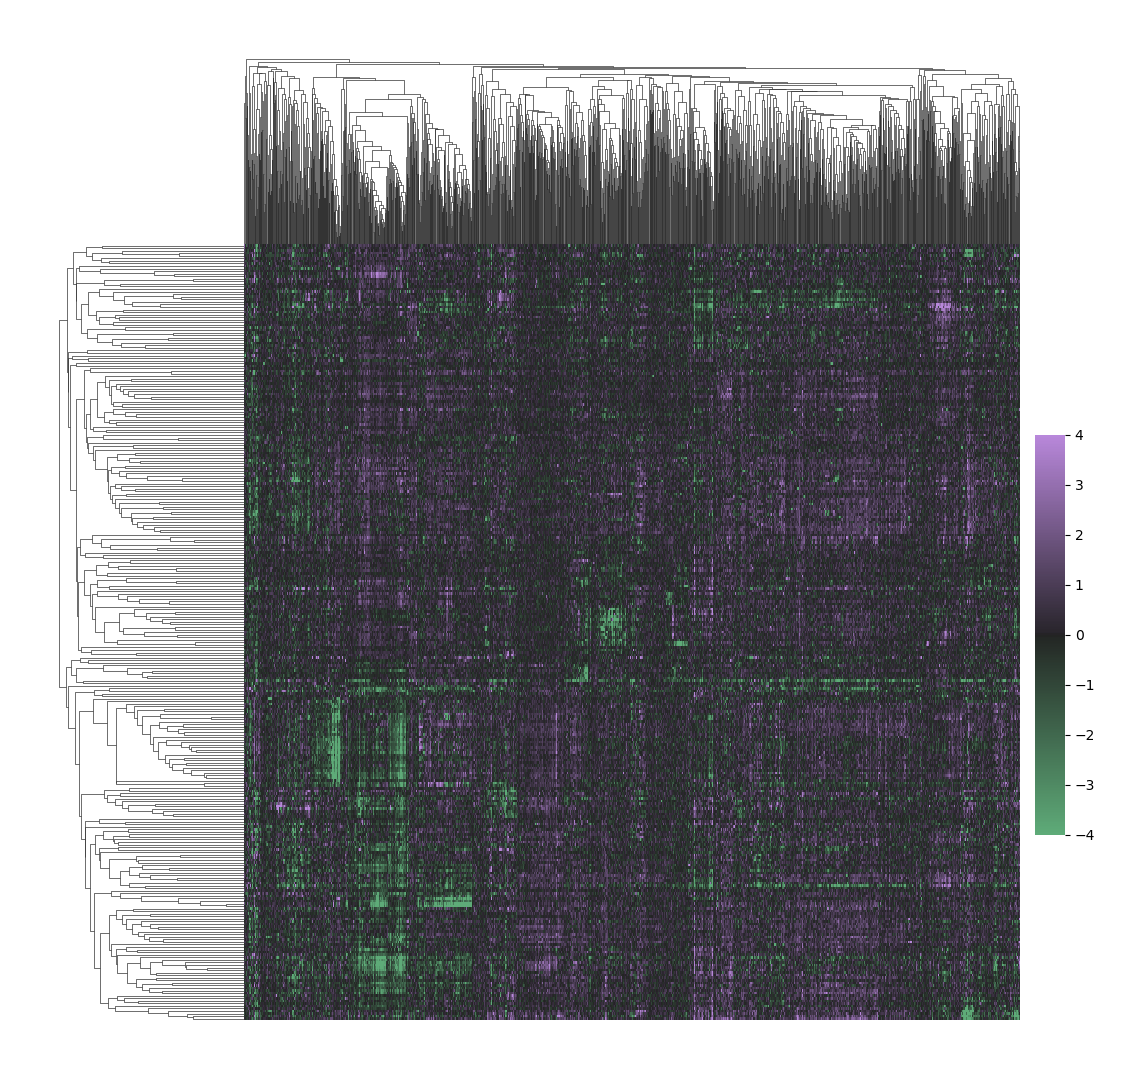

In [12]:
## Generate all clusterings

dmso1_cluster = sns.clustermap(dmso1_map,method = 'average',metric = 'correlation',
                             cmap = blue_yellow,
                             vmin=-4,vmax = 4,
                             cbar_pos=(1, .2, .03, .4),
                             yticklabels=False,xticklabels=False,
                            )

atr_cluster = sns.clustermap(atr_map,method = 'average',metric = 'correlation',
                             cmap = blue_yellow,
                             vmin=-4,vmax = 4,
                             cbar_pos=(1, .2, .03, .4),
                             yticklabels=False,xticklabels=False,
                            )
dmso2_cluster = sns.clustermap(dmso2_map,method = 'average',metric = 'correlation',
                             cmap = blue_yellow,
                             vmin=-4,vmax = 4,
                             cbar_pos=(1, .2, .03, .4),
                             yticklabels=False,xticklabels=False,
                            )
etop_cluster = sns.clustermap(etop_map,method = 'average',metric = 'correlation',
                             cmap = blue_yellow,
                             vmin=-4,vmax = 4,
                             cbar_pos=(1, .2, .03, .4),
                             yticklabels=False,xticklabels=False,
                            )
keto_cluster = sns.clustermap(keto_map,method = 'average',metric = 'correlation',
                             cmap = blue_yellow,
                             vmin=-4,vmax = 4,
                             cbar_pos=(1, .2, .03, .4),
                             yticklabels=False,xticklabels=False,
                            )
atr_di_cluster = sns.clustermap(atr_di_map,method = 'average',metric = 'correlation',
                             cmap = diffColors,
                             vmin=-5,vmax = 5,
                             cbar_pos=(1, .2, .03, .4),
                             yticklabels=False,xticklabels=False,
                            )

concat_cluster = sns.clustermap(concat_map,method = 'average',metric = 'correlation',
                             cmap = diffColors,
                             vmin=-4,vmax = 4,
                             cbar_pos=(1, .2, .03, .4),
                             yticklabels=False,xticklabels=False,
                            )

In [13]:
## Use the clusters generated in the previous cells to reorganize the indices of each map according to its clustering

dmso1_clustered = dmso1_map.iloc[dmso1_cluster.dendrogram_row.reordered_ind,dmso1_cluster.dendrogram_row.reordered_ind]
atr_clustered = atr_map.iloc[atr_cluster.dendrogram_row.reordered_ind,atr_cluster.dendrogram_row.reordered_ind]
dmso2_clustered = dmso2_map.iloc[dmso2_cluster.dendrogram_row.reordered_ind,dmso2_cluster.dendrogram_row.reordered_ind]
etop_clustered = etop_map.iloc[etop_cluster.dendrogram_row.reordered_ind,etop_cluster.dendrogram_row.reordered_ind]
keto_clustered = keto_map.iloc[keto_cluster.dendrogram_row.reordered_ind,keto_cluster.dendrogram_row.reordered_ind]

atr_di_clustered = atr_di_map.iloc[atr_di_cluster.dendrogram_row.reordered_ind,atr_di_cluster.dendrogram_row.reordered_ind]

## Define distance matrices for all five maps and the consensus
dmso1_distance = sp.cluster.hierarchy.linkage(dmso1_map, method='average', metric='correlation')
atr_distance = sp.cluster.hierarchy.linkage(atr_map, method='average', metric='correlation')
dmso2_distance = sp.cluster.hierarchy.linkage(dmso2_map, method='average', metric='correlation')
etop_distance = sp.cluster.hierarchy.linkage(etop_map, method='average', metric='correlation')
keto_distance = sp.cluster.hierarchy.linkage(keto_map, method='average', metric='correlation')

consensus_distance = sp.cluster.hierarchy.linkage(concat_map, method='average', metric='correlation')



In [14]:
## Create cluster matrices for each map, to easily identitfy which genes are in which cluster
dmso1_cluster_matrix = pd.DataFrame(index = dmso1_clustered.index, columns = range(302))

for cluster in dmso1_cluster_matrix.columns:
    branch_identity = []
    deconstruct_tree(cluster,dmso1_distance)
    branch_names = dmso1_map.iloc[branch_identity].index
    for gene in dmso1_cluster_matrix.index:
        if gene in branch_names:
            dmso1_cluster_matrix.loc[gene,cluster] = True
        else:
            dmso1_cluster_matrix.loc[gene,cluster] = False
            

In [15]:
atr_cluster_matrix = pd.DataFrame(index = atr_clustered.index, columns = range(302))

for cluster in atr_cluster_matrix.columns:
    branch_identity = []
    deconstruct_tree(cluster,atr_distance)
    branch_names = atr_map.iloc[branch_identity].index
    for gene in atr_cluster_matrix.index:
        if gene in branch_names:
            atr_cluster_matrix.loc[gene,cluster] = True
        else:
            atr_cluster_matrix.loc[gene,cluster] = False

In [16]:
dmso2_cluster_matrix = pd.DataFrame(index = dmso2_clustered.index, columns = range(302))

for cluster in dmso2_cluster_matrix.columns:
    branch_identity = []
    deconstruct_tree(cluster,dmso2_distance)
    branch_names = dmso2_map.iloc[branch_identity].index
    for gene in dmso2_cluster_matrix.index:
        if gene in branch_names:
            dmso2_cluster_matrix.loc[gene,cluster] = True
        else:
            dmso2_cluster_matrix.loc[gene,cluster] = False

In [17]:
etop_cluster_matrix = pd.DataFrame(index = etop_clustered.index, columns = range(302))

for cluster in etop_cluster_matrix.columns:
    branch_identity = []
    deconstruct_tree(cluster,etop_distance)
    branch_names = etop_map.iloc[branch_identity].index
    for gene in etop_cluster_matrix.index:
        if gene in branch_names:
            etop_cluster_matrix.loc[gene,cluster] = True
        else:
            etop_cluster_matrix.loc[gene,cluster] = False

In [19]:
keto_cluster_matrix = pd.DataFrame(index = keto_clustered.index, columns = range(302))

for cluster in keto_cluster_matrix.columns:
    branch_identity = []
    deconstruct_tree(cluster,keto_distance)
    branch_names = keto_map.iloc[branch_identity].index
    for gene in keto_cluster_matrix.index:
        if gene in branch_names:
            keto_cluster_matrix.loc[gene,cluster] = True
        else:
            keto_cluster_matrix.loc[gene,cluster] = False

In [ ]:
####

In [ ]:
#### The following cells are used to draw annotated GI heatmaps for each condition 

In [ ]:
#### 

In [20]:
## make a upper triangle mask to apply to each map
pd.set_option('future.no_silent_downcasting', True)
dmso2_mask = pd.DataFrame(index = dmso2_clustered.index,columns = dmso2_clustered.columns)

for i in range(len(dmso2_mask.index)):
    for j in range(i,len(dmso2_mask.columns)):
        if i != j:
            dmso2_mask.iloc[j,i] = True
dmso2_mask = dmso2_mask.fillna(False)

etop_mask = pd.DataFrame(index = etop_clustered.index,columns = etop_clustered.columns)

for i in range(len(etop_mask.index)):
    for j in range(i,len(etop_mask.columns)):
        if i != j:
            etop_mask.iloc[j,i] = True
etop_mask = etop_mask.fillna(False)

keto_mask = pd.DataFrame(index = keto_clustered.index,columns = keto_clustered.columns)

for i in range(len(keto_mask.index)):
    for j in range(i,len(keto_mask.columns)):
        if i != j:
            keto_mask.iloc[j,i] = True
keto_mask = keto_mask.fillna(False)

dmso1_mask = pd.DataFrame(index = dmso1_clustered.index,columns = dmso1_clustered.columns)

for i in range(len(dmso1_mask.index)):
    for j in range(i,len(dmso1_mask.columns)):
        if i != j:
            dmso1_mask.iloc[j,i] = True
dmso1_mask = dmso1_mask.fillna(False)

atr_mask = pd.DataFrame(index = atr_clustered.index,columns = atr_clustered.columns)

for i in range(len(atr_mask.index)):
    for j in range(i,len(atr_mask.columns)):
        if i != j:
            atr_mask.iloc[j,i] = True
atr_mask = atr_mask.fillna(False)

atr_di_mask = pd.DataFrame(index = atr_di_clustered.index,columns = atr_di_clustered.columns)

for i in range(len(atr_di_mask.index)):
    for j in range(i,len(atr_di_mask.columns)):
        if i != j:
            atr_di_mask.iloc[j,i] = True
atr_di_mask = atr_di_mask.fillna(False)

In [21]:
## Define distance threshold values for low and high confidence clustering 

low = 0.55
high = 0.8

In [22]:
## Define lists of clusters for each map that are in each cluster threshold, then draw the map, with mask and
## cluster colorbar

dmso2_low_clusters = cluster_thresh(dmso2_distance,low)
dmso2_high_clusters = cluster_thresh(dmso2_distance,high)
dmso2_cluster_color = pd.DataFrame(index = dmso2_map.index,columns=['high','low'])

for item in dmso2_high_clusters:
    gl = dmso2_cluster_matrix.loc[dmso2_cluster_matrix[item-303]].index
    for gene in gl:
        dmso2_cluster_color.loc[gene,'high'] = 'firebrick'
for item in dmso2_low_clusters:
    gl = dmso2_cluster_matrix.loc[dmso2_cluster_matrix[item-303]].index
    for gene in gl:
        dmso2_cluster_color.loc[gene,'low'] = 'lightcoral'
        
dmso2_cluster_color = dmso2_cluster_color.fillna('black')

/opt/anaconda3/envs/circos/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/circos/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


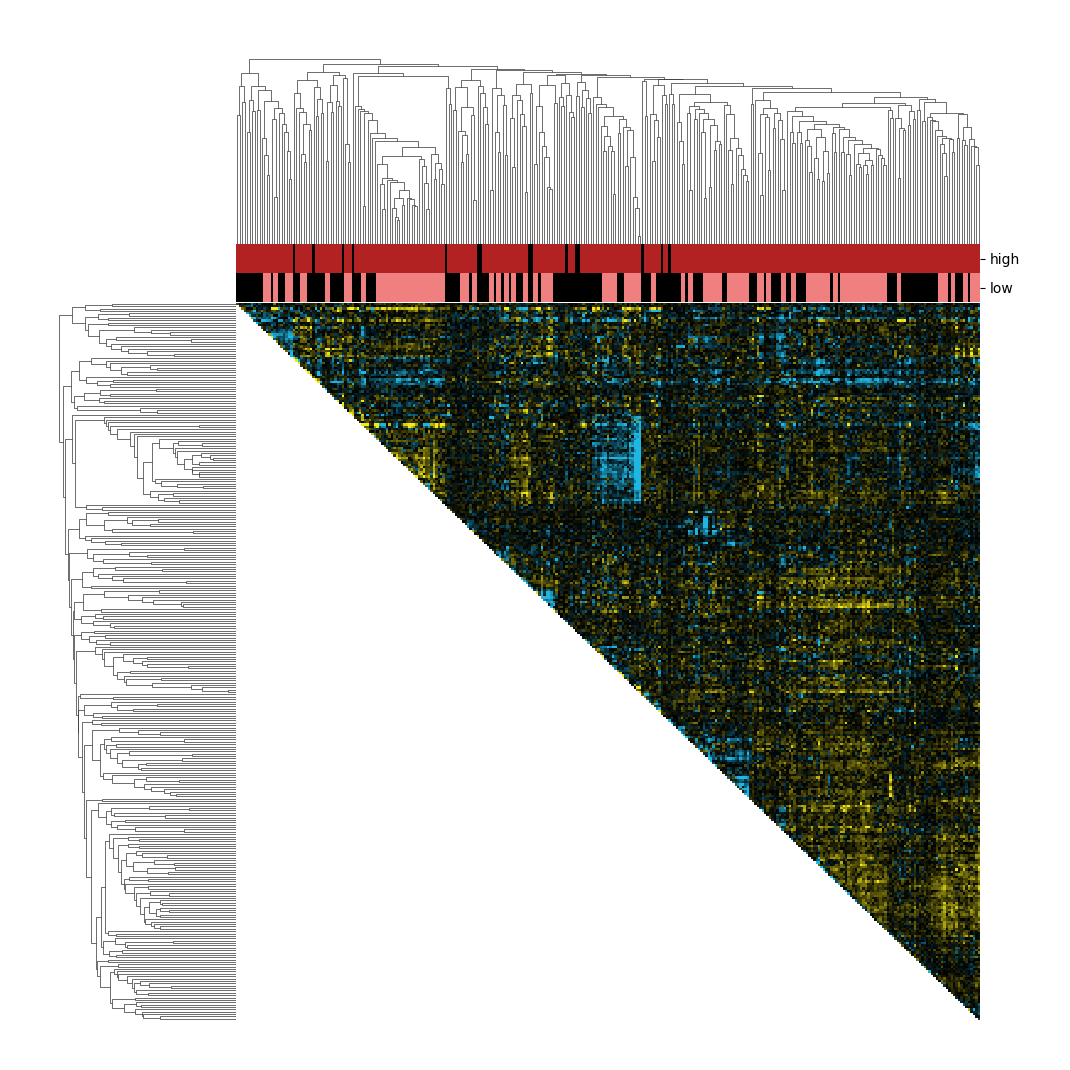

In [23]:
clustermap(dmso2_clustered,method = 'average',metric = 'correlation',
           cmap = blue_yellow,
           vmin=-4,vmax = 4,
           cbar_pos= None,#(1, .2, .03, .4),
           yticklabels=False,xticklabels=False,
           col_colors = dmso2_cluster_color,
           #colors_ratio = (0,0.010),
           #dendrogram_ratio= (0.10,0),
           figsize=(10,10),
           mask = dmso2_mask
          )

#plt.savefig('/Users/benh/Desktop/for_figs/dmso2_clustermap.png',dpi = 300)

In [21]:
etop_low_clusters = cluster_thresh(etop_distance,low)
etop_high_clusters = cluster_thresh(etop_distance,high)
etop_cluster_color = pd.DataFrame(index = etop_map.index,columns=['high','low'])

for item in etop_high_clusters:
    gl = etop_cluster_matrix.loc[etop_cluster_matrix[item-303]].index
    for gene in gl:
        etop_cluster_color.loc[gene,'high'] = 'orange'
for item in etop_low_clusters:
    gl = etop_cluster_matrix.loc[etop_cluster_matrix[item-303]].index
    for gene in gl:
        etop_cluster_color.loc[gene,'low'] = 'moccasin'
        
etop_cluster_color = etop_cluster_color.fillna('black')

/opt/anaconda3/envs/circos/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/circos/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


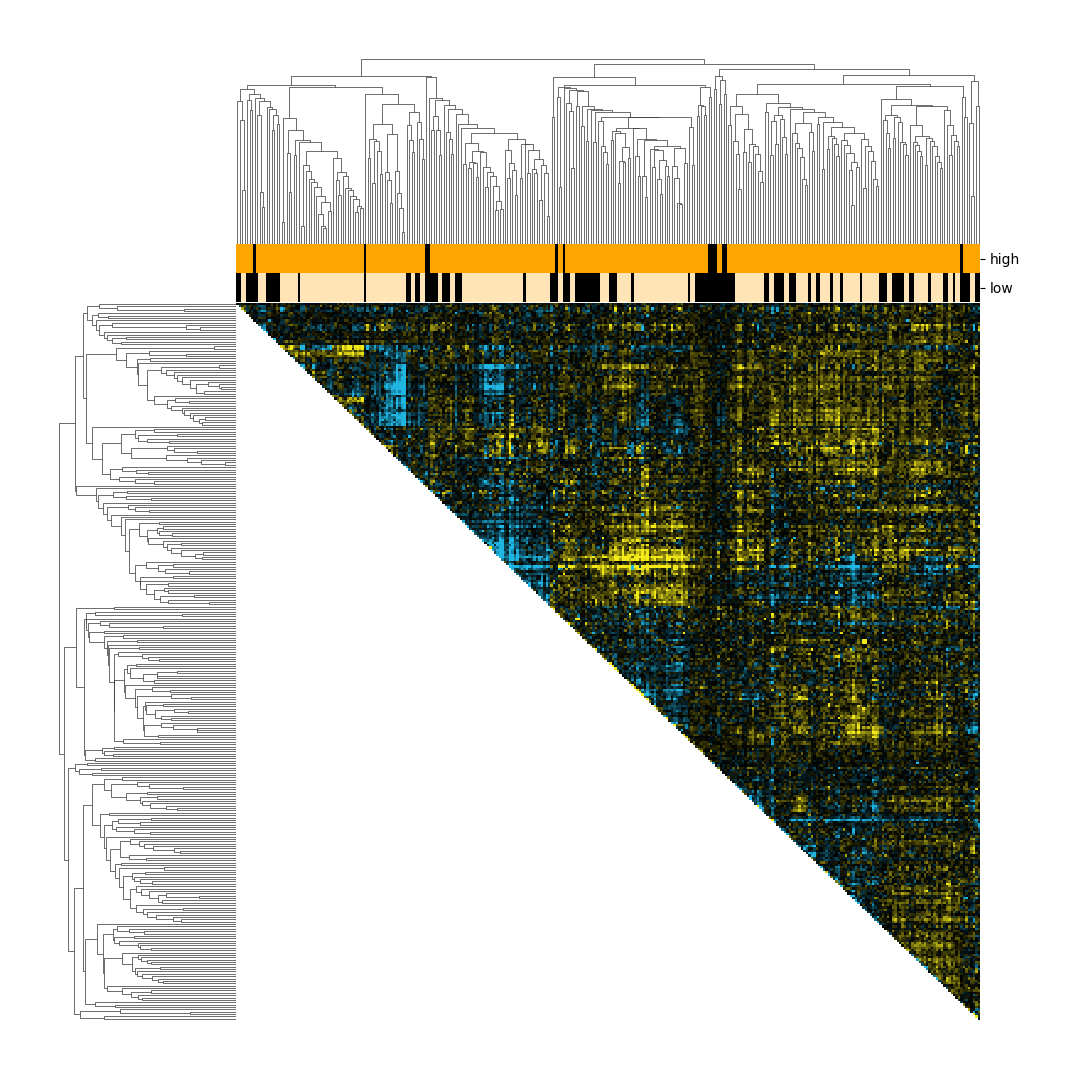

In [23]:
clustermap(etop_clustered,method = 'average',metric = 'correlation',
           cmap = blue_yellow,
           vmin=-4,vmax = 4,
           cbar_pos= None,
           yticklabels=False,xticklabels=False,
           col_colors = etop_cluster_color,
           #dendrogram_ratio= (0,0.15),
           figsize=(10,10),
           mask = etop_mask
          )

#plt.savefig('/Users/benh/Desktop/for_figs/etop_clustermap.png',dpi = 300)

In [24]:
keto_low_clusters = cluster_thresh(keto_distance,low)
keto_high_clusters = cluster_thresh(keto_distance,high)
keto_cluster_color = pd.DataFrame(index = keto_map.index,columns=['high','low'])

for item in keto_high_clusters:
    gl = keto_cluster_matrix.loc[keto_cluster_matrix[item-303]].index
    for gene in gl:
        keto_cluster_color.loc[gene,'high'] = 'firebrick'
for item in keto_low_clusters:
    gl = keto_cluster_matrix.loc[keto_cluster_matrix[item-303]].index
    for gene in gl:
        keto_cluster_color.loc[gene,'low'] = 'lightcoral'
        
keto_cluster_color = keto_cluster_color.fillna('black')

/opt/anaconda3/envs/circos/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/circos/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


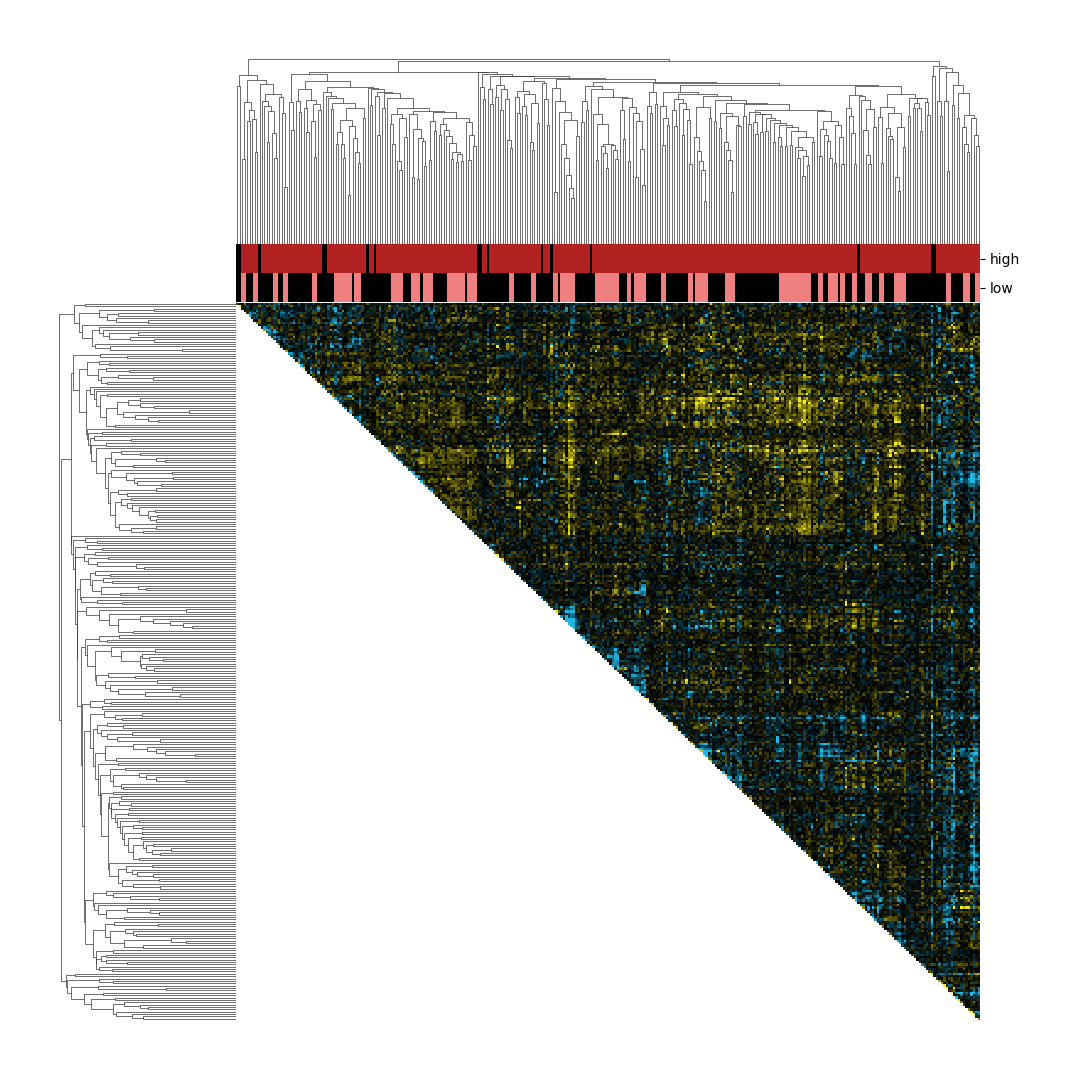

In [26]:
clustermap(keto_clustered,method = 'average',metric = 'correlation',
           cmap = blue_yellow,
           vmin=-4,vmax = 4,
           cbar_pos=None,
           yticklabels=False,xticklabels=False,
           col_colors = keto_cluster_color,
           #dendrogram_ratio= (0,0.15),
           figsize = (10,10),
           mask = keto_mask
          )

#plt.savefig('/Users/benh/Desktop/for_figs/keto_clustermap.png',dpi = 300)

/opt/anaconda3/envs/circos/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/circos/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


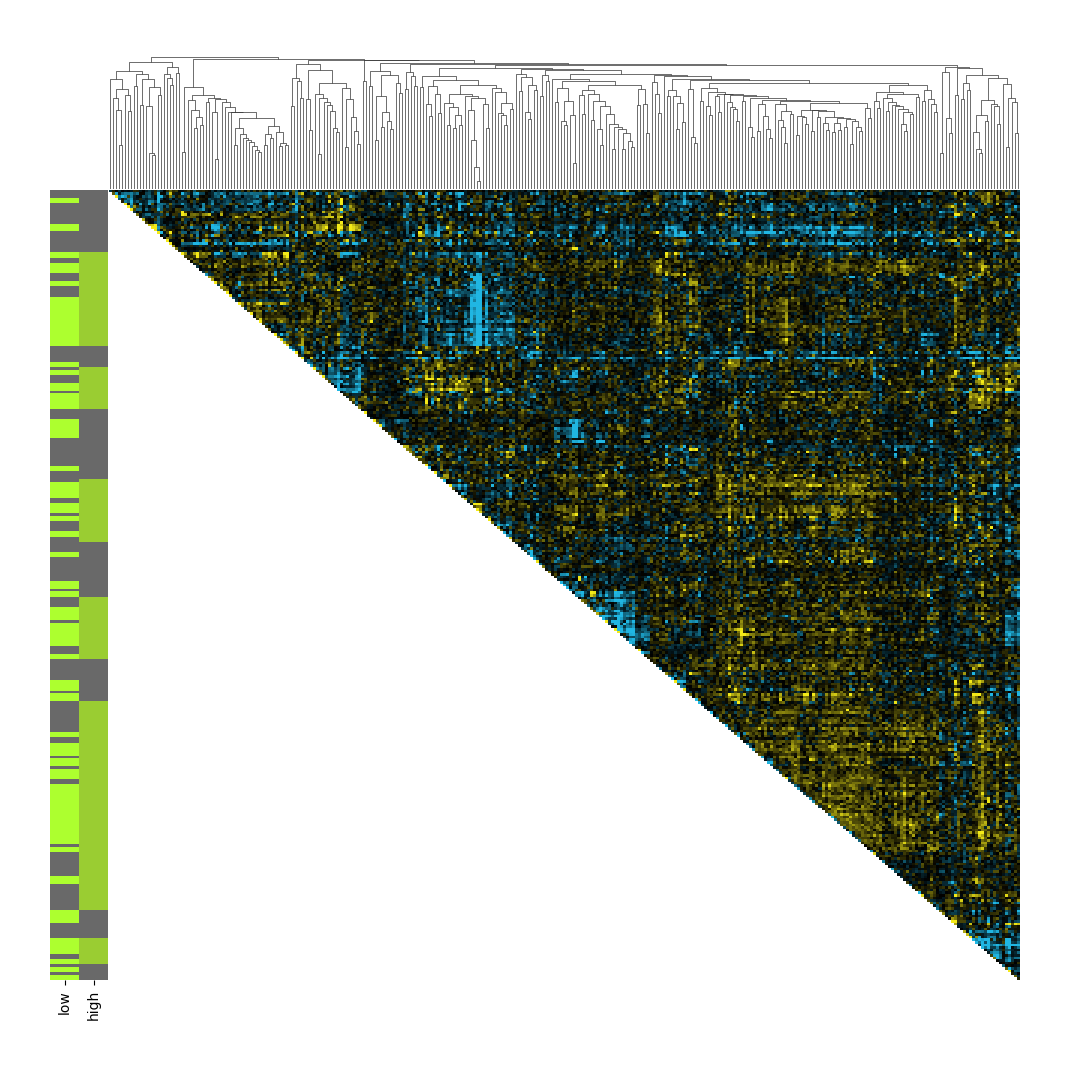

In [28]:
dmso1_low_clusters = cluster_thresh(dmso1_distance,low)
dmso1_high_clusters = cluster_thresh(dmso1_distance,high)
dmso1_cluster_color = pd.DataFrame(index = dmso1_map.index,columns=['low','high'])
dmso1_cmap = cmap = sns.color_palette("tab20_r",20)
for item in dmso1_high_clusters:
    gl = dmso1_cluster_matrix.loc[dmso1_cluster_matrix[item-303]].index
    if len(gl) < 10:
        continue
    for gene in gl:
        dmso1_cluster_color.loc[gene,'high'] = 'yellowgreen'
for item in dmso1_low_clusters:
    gl = dmso1_cluster_matrix.loc[dmso1_cluster_matrix[item-303]].index
    for gene in gl:
        dmso1_cluster_color.loc[gene,'low'] = 'greenyellow'

dmso1_cluster_color = dmso1_cluster_color.fillna('dimgray')

clustermap(dmso1_clustered,method = 'average',metric = 'correlation',
           cmap = blue_yellow,
           vmin=-4,vmax = 4,
           cbar_pos=None,
           yticklabels=False,xticklabels=False,
           row_colors = dmso1_cluster_color,
           dendrogram_ratio= (0,0.15),
           figsize = (10,10),
           mask = dmso1_mask
          )
dmso1_distance = sp.cluster.hierarchy.linkage(dmso1_map, method='average', metric='correlation')


#plt.savefig('/Users/benh/Desktop/for_figs/dmso1_clustermap.png',dpi = 300)

/opt/anaconda3/envs/circos/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/circos/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


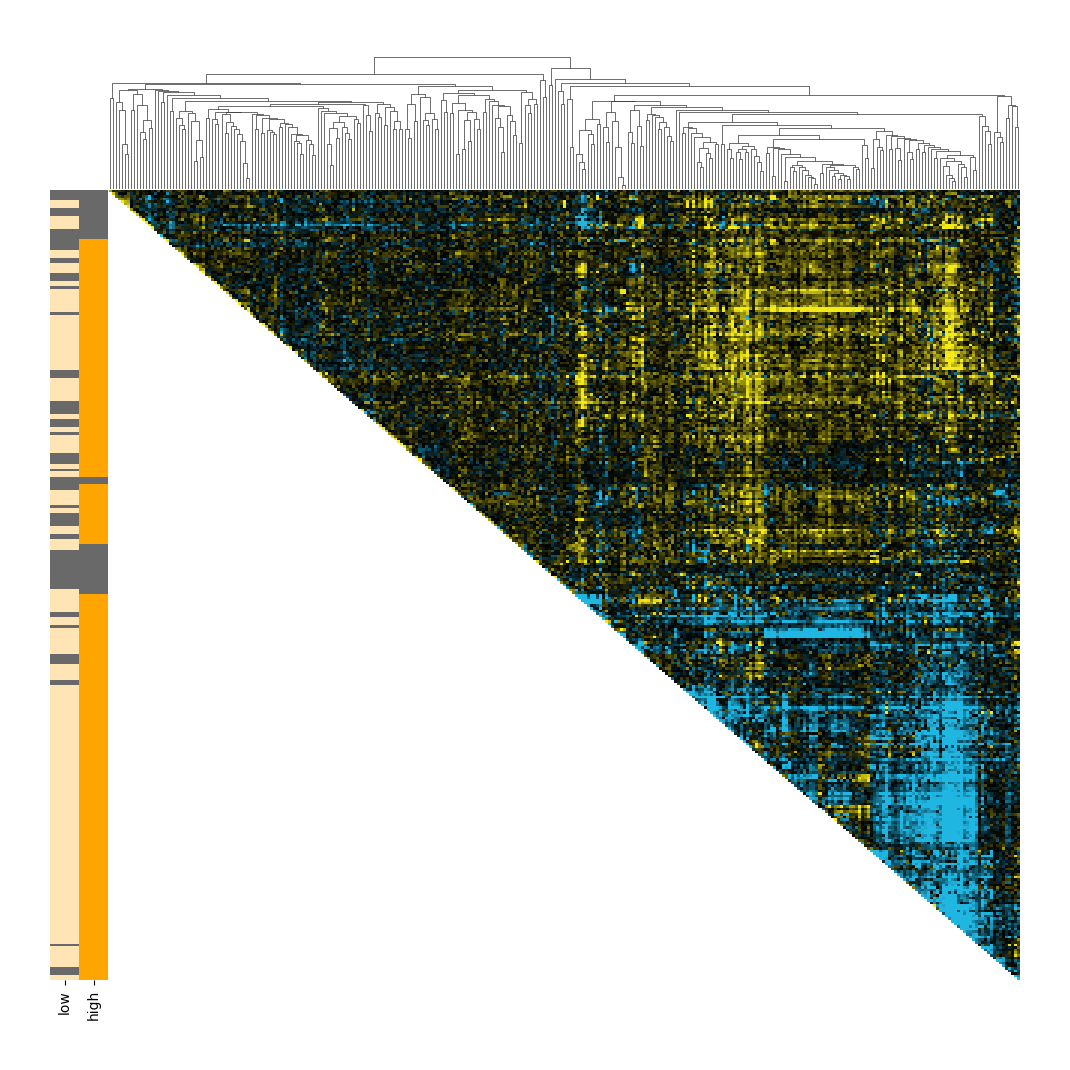

In [30]:
atr_low_clusters = cluster_thresh(atr_distance,low)
atr_high_clusters = cluster_thresh(atr_distance,high)
atr_cluster_color = pd.DataFrame(index = atr_map.index,columns=['low','high'])

for item in atr_high_clusters:
    gl = atr_cluster_matrix.loc[atr_cluster_matrix[item-303]].index
    if len(gl) < 10:
        continue
    for gene in gl:
        atr_cluster_color.loc[gene,'high'] = 'orange'
for item in atr_low_clusters:
    gl = atr_cluster_matrix.loc[atr_cluster_matrix[item-303]].index
    for gene in gl:
        atr_cluster_color.loc[gene,'low'] = 'moccasin'
        
atr_cluster_color = atr_cluster_color.fillna('dimgray')
clustermap(atr_clustered,method = 'average',metric = 'correlation',
           cmap = blue_yellow,
           vmin=-4,vmax = 4,
           cbar_pos=None,
           yticklabels=False,xticklabels=False,
           row_colors = atr_cluster_color,
           dendrogram_ratio= (0,0.15),
           figsize = (10,10),
           mask = atr_mask
          )

#plt.savefig('/Users/benh/Desktop/for_figs/atr_clustermap.png',dpi = 300)


/opt/anaconda3/envs/circos/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


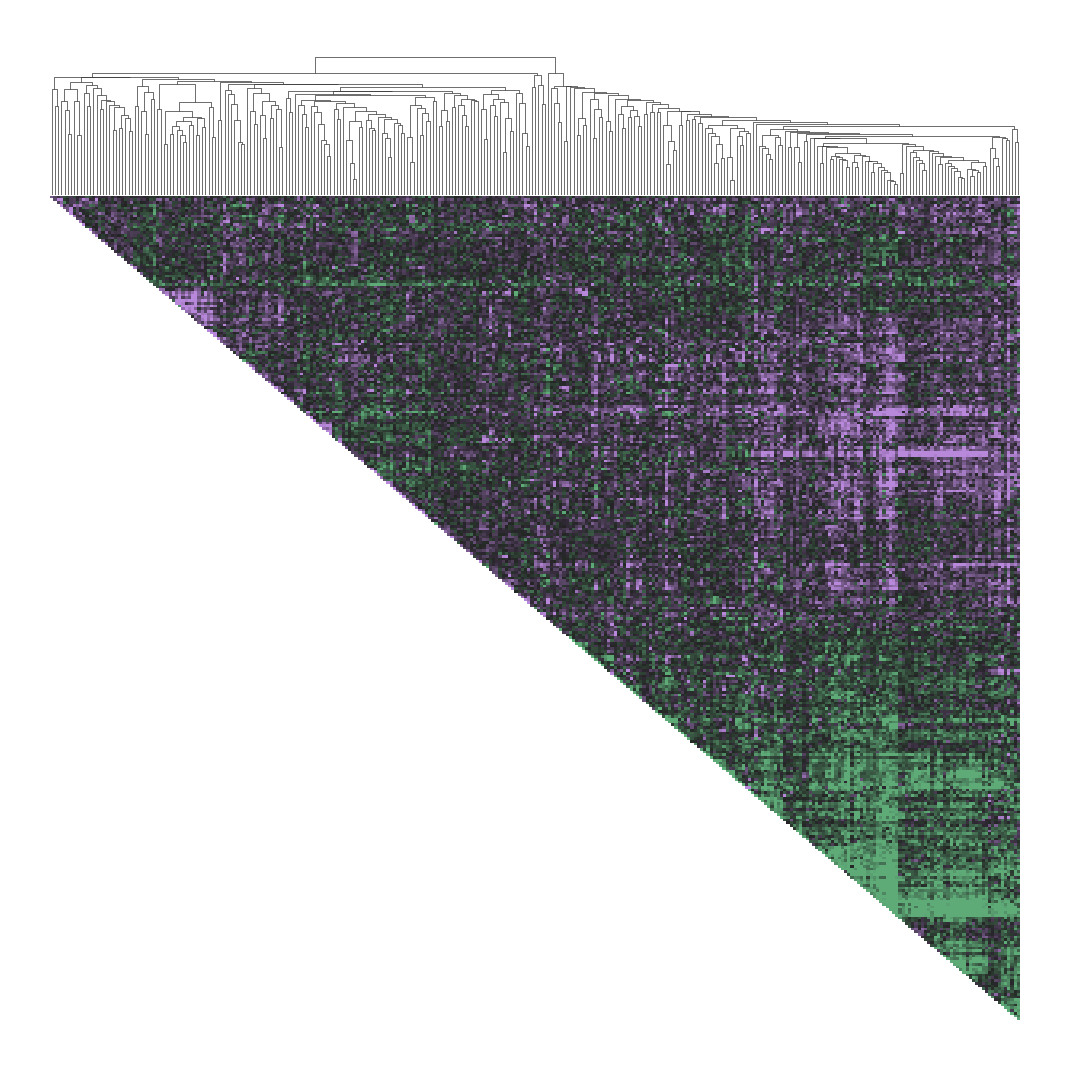

In [32]:
clustermap(atr_di_clustered,method = 'average',metric = 'correlation',
           cmap = diffColors,
           vmin=-4,vmax = 4,
           cbar_pos=None,
           yticklabels=False,xticklabels=False,
           #col_colors = active_cluster_color,
           dendrogram_ratio= (0.0,0.15),
           figsize = (10,10),
           mask = atr_di_mask
          )
#plt.savefig('/Users/benh/Desktop/for_figs/atr_di_map.png',dpi=300)

In [ ]:
####

In [ ]:
#### The following cells are used to determine the number of conserved clusters in the consensus matrix 

In [ ]:
####

In [33]:
## Make cluster matrices for the consensus map and well as each individual map
    
consensus_cluster_matrix = pd.DataFrame(index = concat_map.index, columns = range(302))

for cluster in consensus_cluster_matrix.columns:
    branch_identity = []
    deconstruct_tree(cluster,consensus_distance)
    branch_names = concat_map.iloc[branch_identity].index
    for gene in consensus_cluster_matrix.index:
        if gene in branch_names:
            consensus_cluster_matrix.loc[gene,cluster] = True
        else:
            consensus_cluster_matrix.loc[gene,cluster] = False

(0.0, 60.0)

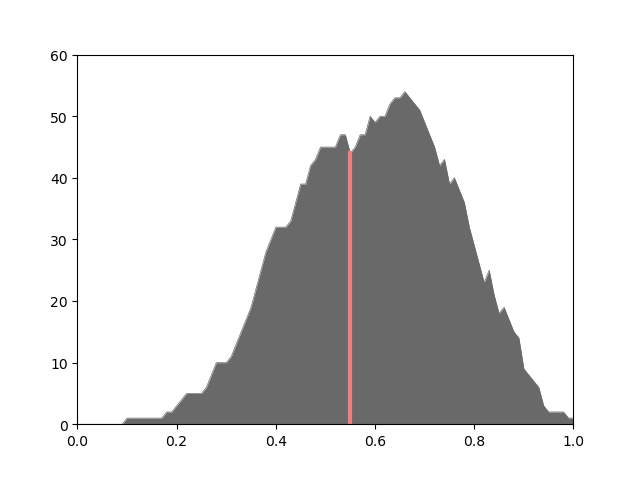

In [34]:
## calculate how many clusters are generated for a range of pearson thresholds in the consensus distance matrix
## this should help us decide what pearson threshold yields a reasonable number of clusters without collapsing 
## information

cluster_thresh_list = []
for i in np.arange(0,1.1,0.01):
    cluster_thresh_list.append(len(cluster_thresh(consensus_distance,i)))
plt.plot(np.arange(0,1.1,0.01),cluster_thresh_list,c='dimgray')
#plt.savefig('/Users/benh/Desktop/UCSF_Tetrad_Program/Gilbert_Lab/gi2/plots/cluster_formation.png',dpi=300)

plt.fill_between(np.arange(0,1.1,0.01),cluster_thresh_list,color='dimgray')
plt.plot((0.55,0.55),(0,44),c='lightcoral',lw=3)
plt.xlim(0,1)
plt.ylim(0,60)
#plt.savefig('/Users/benh/Desktop/for_figs/concensus_cluster_formation.png',dpi=300)

In [35]:
## Take a slice of the consensus disance matrix based on the threshold determined in the previous cell 
tree_slice1 = cluster_thresh(consensus_distance,0.55)

In [36]:
## Set up a dataframe that we will subsequentely populate with annotations for the consensus list of clusters
consensus_annotations = pd.DataFrame(index = tree_slice1,columns = ['Term','Genes'])
 

In [42]:
## Quickly fetch the gene list of each consensus cluster. "i" must be an integer between 0 and 43
i=35
for item in list(consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]==True].index):
    print(item)



MAX
SLC7A1
FBXO5
TCERG1


In [ ]:
## These genes lists are manually fed into MSIGDB (I know, I know) with the three GO term libraries used to 
## determine GO enrichment, if any, for that cluster. Below, we add those annotation, one at a time, to the
## dataframe defined above. If there is no GO term annotated with a pval<1e-5, we label it "no_go" and move on
## to the next cluster. In instances where there is no enriched GO term, or an enriched GO term that is not descriptive and the set of genes
## are all highly researched components of an easily recognizable complex or ontology (e.g. BRCA1, BARD1) we will manually annotate that 
## cluster as such. Below are all instances where I have done this. Additionally, in one case (cluster #4, CCDC6/FBXO42) we have labeled it
## with the genes names of the cluster despite no GO or known association because it is discussed in the manuscript. 
## I'm doing it this way because I'm too stupid and lazy to figure out the MSIGDB API and GO term often are not descriptive and suck

## Manually annotated clusters: 4, 7, 19, 21, 28, 29, 31, 36

In [ ]:
i = 0
consensus_annotations.loc[tree_slice1[i],'Term'] = 'MICOS_complex'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## GOCC_MICOS_COMPLEX [9] - 3.97 e-8

i = 1
consensus_annotations.loc[tree_slice1[i],'Term'] = 'BRCA1_complex'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## GOCC_BRCA1_C_COMPLEX [6] - 1.65 e-8

i = 2
consensus_annotations.loc[tree_slice1[i],'Term'] = 'translation_initiation'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## GOBP_FORMATION_OF_TRANSLATION_PREINITIITIATION_COMPLEX [9] - 3.97 e-8

i = 3
consensus_annotations.loc[tree_slice1[i],'Term'] = 'TATA_binding_protein'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## GOMF_TBP_CLASS_PROTEIN_BINDING [25] - 3.31 e-7

i = 4
consensus_annotations.loc[tree_slice1[i],'Term'] = 'CCDC6/FBXO42'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## NO GO
## Manually annotated 

i = 5
consensus_annotations.loc[tree_slice1[i],'Term'] = 'none'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## NO GO

i = 6
consensus_annotations.loc[tree_slice1[i],'Term'] = 'RFC_complex'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## GOCC_CTF18_RFC_LIKE_COMPLEX [8] - 3.09 e-8

i = 7
consensus_annotations.loc[tree_slice1[i],'Term'] = 'CST_complex'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]## GOMF_TELOMERIC_DNA_BINDING [39] - 8.18 e-7
## GOCC_CHROMOSOME_TELOMERIC_REPEAT_REGION [14] - 1 e-7
## Manual annotation as CST complex

i = 8
consensus_annotations.loc[tree_slice1[i],'Term'] = 'none'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## NO GO

i = 9
consensus_annotations.loc[tree_slice1[i],'Term'] = 'none'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## NO GO

i = 10
consensus_annotations.loc[tree_slice1[i],'Term'] = 'diphthamide_biosynthesis'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## GOBP_PROTEIN_HISTIDYL_MODIFICATION_TO_DIPHTHAMIDE [7] - 2.72 e-12

i = 11
consensus_annotations.loc[tree_slice1[i],'Term'] = 'golgi_transport'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## GOBP_RETROGRADE_VESICLE_MEDIATED_TRANSANSPORT_GOLGI_TO_ENDOPLASMIC_RETICULUM [52] - 1.46 e-6

i = 12
consensus_annotations.loc[tree_slice1[i],'Term'] = 'cohesin'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## GOCC_MITOTIC_COHESIN_COMPLEX [7] - 2.32 e-8

i = 13
consensus_annotations.loc[tree_slice1[i],'Term'] = 'n6a_mehthyltransferase'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## GOCC_METHYLTRANSFERASE_COMPLEX [102] - 1.33 e-8

i = 14
consensus_annotations.loc[tree_slice1[i],'Term'] = 'MRN_complex'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## GOCC_MRE11_COMPLEX [5] - 1.1 e-8

i = 15
consensus_annotations.loc[tree_slice1[i],'Term'] = 'histone_methyltransferase'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## GOCC_HISTONE_METHYLTRANSFERASE_COMPLEX [70] - 2.66 e-6

i = 16
consensus_annotations.loc[tree_slice1[i],'Term'] = 'none'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## NO GO

i = 17
consensus_annotations.loc[tree_slice1[i],'Term'] = 'pyrimidine_biosynthesis'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## GOBP_PYRIMIDINE_DEOXYRIBONUCLEOSIDE_TRIPHOSPHATE_METABOLIC_PROCESS [6] - 1.65 e-8

i = 18
consensus_annotations.loc[tree_slice1[i],'Term'] = 'PP2A'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## GOCC_PROTEIN_PHOSPHATASE_TYPE_2A_COMPLEX [18] - 1.69 e-7

i = 19
consensus_annotations.loc[tree_slice1[i],'Term'] = 'splicing'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## NO GO
## Manually annotated as "splicing"

i = 20
consensus_annotations.loc[tree_slice1[i],'Term'] = 'SAGA_complex'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## GOCC_SAGA_COMPLEX [25] - 3.31 e-7

i = 21
consensus_annotations.loc[tree_slice1[i],'Term'] = 'ubi_degradation'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## NO GO
## Manually annotated as "ubi_degradation"

i = 22
consensus_annotations.loc[tree_slice1[i],'Term'] = 'none'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## NO GO

i = 23
consensus_annotations.loc[tree_slice1[i],'Term'] = 'one_carbon_metabolism'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## GOBP_ONE_CARBON_METABOLIC_PROCESS [40] - 7.68 e-10

i = 24
consensus_annotations.loc[tree_slice1[i],'Term'] = 'none'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## NO GO

i = 25
consensus_annotations.loc[tree_slice1[i],'Term'] = 'tRNA_wobble_modification'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## GOBP_TRNA_WOBBLE_BASE_MODIFICATION [20] - 3.54 e-14

i = 26
consensus_annotations.loc[tree_slice1[i],'Term'] = 'none'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## NO GO

i = 27
consensus_annotations.loc[tree_slice1[i],'Term'] = 'B_cell_differentiation'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## GOBP_REGULATION_OF_PRO_B_CELL_DIFFERENTIATION [8] - 3.09 e-8

i = 28
consensus_annotations.loc[tree_slice1[i],'Term'] = 'MTOR_signal_transduction'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## NO GO
## Manually annotated

i = 29
consensus_annotations.loc[tree_slice1[i],'Term'] = 'TIP60'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## GOCC_H4_H2A_HISTONE_ACETYLTRANSFERASE_COMPLEX [32] - 6.69 e-23
## Manually annotated

i = 30
consensus_annotations.loc[tree_slice1[i],'Term'] = 'neddylation'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## GOBP_PROTEIN_NEDDYLATION [28] - 2.54 e-9

i = 31
consensus_annotations.loc[tree_slice1[i],'Term'] = 'G2M_checkpoint'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## NO GO
## Manually annotated

i = 32
consensus_annotations.loc[tree_slice1[i],'Term'] = 'DNA_recombinase'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## GOBP_RECOMBINATIONAL_REPAIR [192] - 7.77 e-15

i = 33
consensus_annotations.loc[tree_slice1[i],'Term'] = 'none'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## NO GO 

i = 34
consensus_annotations.loc[tree_slice1[i],'Term'] = 'none'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## NO GO

i = 35
consensus_annotations.loc[tree_slice1[i],'Term'] = 'none'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## NO GO

i = 36
consensus_annotations.loc[tree_slice1[i],'Term'] = 'DSB_repair'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## GOCC_DNA_REPAIR_COMPLEX [22] - 7.64 e-7
## Manually annotated

i = 37
consensus_annotations.loc[tree_slice1[i],'Term'] = 'none'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## NO GO

i = 38
consensus_annotations.loc[tree_slice1[i],'Term'] = 'none'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## NO GO

i = 39
consensus_annotations.loc[tree_slice1[i],'Term'] = 'FANC_complex'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## GOCC_FANCONI_ANAEMIA_NUCLEAR_COMPLEX [13] - 5.16 e-7

i = 40
consensus_annotations.loc[tree_slice1[i],'Term'] = 'mitochondrial_homeostasis'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## GOBP_MITOCHONDRIAL_RESPIRATORY_CHAIN_COMPLEX_ASSEMBLY [101] - 4.3 e-9

i = 41
consensus_annotations.loc[tree_slice1[i],'Term'] = 'none'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## NO GO

i = 42
consensus_annotations.loc[tree_slice1[i],'Term'] = 'glycolysis'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## GOBP_GLUCOSE_METABOLIC_PROCESS [193] - 9.11 e-7

i = 43
consensus_annotations.loc[tree_slice1[i],'Term'] = 'core_cell_cycle'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]
## GOBP_CELL_DIVISION [644] - 5.19 e-8


In [38]:
## here is a list of all the MSIGDB generated labels for every conserved complex. "none" if no significantly enriched GO term

msig_labels = [
    'GOCC_MICOS_COMPLEX',
    'GOCC_BRCA1_C_COMPLEX',
    'GOBP_FORMATION_OF_TRANSLATION_PREINITIITIATION_COMPLEX',
    'GOMF_TBP_CLASS_PROTEIN_BINDING',
    'none',
    'none',
    'GOCC_CTF18_RFC_LIKE_COMPLEX',
    'GOCC_CHROMOSOME_TELOMERIC_REPEAT_REGION',
    'none',
    'none',
    'GOBP_PROTEIN_HISTIDYL_MODIFICATION_TO_DIPHTHAMIDE',
    'GOBP_RETROGRADE_VESICLE_MEDIATED_TRANSANSPORT_GOLGI_TO_ENDOPLASMIC_RETICULUM',
    'GOCC_MITOTIC_COHESIN_COMPLEX',
    'GOCC_METHYLTRANSFERASE_COMPLEX',
    'GOCC_MRE11_COMPLEX',
    'GOCC_HISTONE_METHYLTRANSFERASE_COMPLEX',
    'none',
    'GOBP_PYRIMIDINE_DEOXYRIBONUCLEOSIDE_TRIPHOSPHATE_METABOLIC_PROCESS',
    'GOCC_PROTEIN_PHOSPHATASE_TYPE_2A_COMPLEX',
    'none',
    'GOCC_SAGA_COMPLEX', 
    'none',
    'none',
    'GOBP_ONE_CARBON_METABOLIC_PROCESS',
    'none',
    'GOBP_TRNA_WOBBLE_BASE_MODIFICATION',
    'none',
    'GOBP_REGULATION_OF_PRO_B_CELL_DIFFERENTIATION',
    'none',
    'GOCC_H4_H2A_HISTONE_ACETYLTRANSFERASE_COMPLEX',
    'GOBP_PROTEIN_NEDDYLATION',
    'none',
    'GOBP_RECOMBINATIONAL_REPAIR',
    'none',
    'none',
    'none',
    'GOCC_DNA_REPAIR_COMPLEX',
    'none',
    'none',
    'GOCC_FANCONI_ANAEMIA_NUCLEAR_COMPLEX',
    'GOBP_MITOCHONDRIAL_RESPIRATORY_CHAIN_COMPLEX_ASSEMBLY',
    'none',
    'GOBP_GLUCOSE_METABOLIC_PROCESS',
    'GOBP_CELL_DIVISION']

In [ ]:
## Reset the index, and enumerate the different non-GO enriched clusters 
consensus_annotations = consensus_annotations.reset_index()
count = 0
ont_list = []
ont_cluster_list = []
for item in consensus_annotations.index:
    if consensus_annotations.loc[item,'Term'] == 'none':
        ont_list.append('no_GO_'+str(count))
        count += 1
        ont_cluster_list.append(consensus_annotations.loc[item,'index']-303)
        continue
    ont_list.append(consensus_annotations.loc[item,'Term'])
    ont_cluster_list.append(consensus_annotations.loc[item,'index']-303)

consensus_annotations['Term'] = ont_list


In [ ]:
## make a version of the consensus cluster dataframe for export, include the MSIGDB names

consensus_annotations_export = consensus_annotations.iloc[:,1:3]
consensus_annotations_export['MSIGDB_name'] = msig_labels
consensus_annotations_export = consensus_annotations_export.set_index('Term')
consensus_annotations_export.to_excel('/Users/benh/Desktop/GI_data/misc/consensus_ontologies.xlsx')

In [ ]:
## Make Non-normalized versions of each ontology map

dmso1_ont_map,dmso1_ont_std = make_ont_map(ont_list,ont_cluster_list,dmso1_map,consensus_cluster_matrix)
dmso2_ont_map,dmso2_ont_std = make_ont_map(ont_list,ont_cluster_list,dmso2_map,consensus_cluster_matrix)
atr_ont_map,atr_ont_std = make_ont_map(ont_list,ont_cluster_list,atr_map,consensus_cluster_matrix)
etop_ont_map,etop_ont_std = make_ont_map(ont_list,ont_cluster_list,etop_map,consensus_cluster_matrix)
keto_ont_map,keto_ont_std = make_ont_map(ont_list,ont_cluster_list,keto_map,consensus_cluster_matrix)


In [ ]:
## Write ont maps

dmso1_ont_map.to_excel('/Users/benh/Desktop/GI_data/ont_maps/dmso1_ont_map.xlsx')
dmso1_ont_map = pd.read_excel('/Users/benh/Desktop/GI_data/ont_maps/dmso1_ont_map.xlsx',index_col=0)
dmso2_ont_map.to_excel('/Users/benh/Desktop/GI_data/ont_maps/dmso2_ont_map.xlsx')
dmso2_ont_map = pd.read_excel('/Users/benh/Desktop/GI_data/ont_maps/dmso2_ont_map.xlsx',index_col=0)
atr_ont_map.to_excel('/Users/benh/Desktop/GI_data/ont_maps/atr_ont_map.xlsx')
atr_ont_map = pd.read_excel('/Users/benh/Desktop/GI_data/ont_maps/atr_ont_map.xlsx',index_col=0)
etop_ont_map.to_excel('/Users/benh/Desktop/GI_data/ont_maps/etop_ont_map.xlsx')
etop_ont_map = pd.read_excel('/Users/benh/Desktop/GI_data/ont_maps/etop_ont_map.xlsx',index_col=0)
keto_ont_map.to_excel('/Users/benh/Desktop/GI_data/ont_maps/keto_ont_map.xlsx')
keto_ont_map = pd.read_excel('/Users/benh/Desktop/GI_data/ont_maps/keto_ont_map.xlsx',index_col=0)

In [ ]:
## Make a color map that generates a number of colors equivalent to the number of clusters in the consensus 
## annotation and used those to populate a dictionary with keys equivalent to each cluster and values equivalent to the associated color

cmap = sns.color_palette("husl",len(ont_list))
ont_color_key = dict()
for i in range(len(ont_list)):
    ont_color_key[ont_list[i]] = cmap[i]

In [ ]:
## Make differential ont maps

dmso_di_ont_map = dmso2_ont_map - dmso1_ont_map
atr_di_ont_map = atr_ont_map - dmso1_ont_map
etop_di_ont_map = etop_ont_map - dmso2_ont_map
keto_di_ont_map = keto_ont_map - dmso2_ont_map

In [ ]:
## Grab map specific thersholds from "differential_analysis" notebook

dmso2_thresh = 3.403404848545315
etop_thresh = 3.0725984290302044
keto_thresh = 3.3499189170265193
dmso1_thresh = 3.516019051020592
atr_thresh = 3.1814800400738763

dmso_di_thresh = 5.586391215221745
atr_di_thresh = 5.235884266048073
etop_di_thresh = 4.683534588231303
keto_di_thresh = 4.610517297522741



In [ ]:
## Make correlation matrices for each map

dmso2_corr = dmso2_map.corr('pearson')
etop_corr = etop_map.corr('pearson')
keto_corr = keto_map.corr('pearson')

dmso1_corr = dmso1_map.corr('pearson')
atr_corr = atr_map.corr('pearson')

concat_map_y = concat_sgmap = pd.concat((dmso2_norm,etop_norm,keto_norm,dmso1_norm,atr_norm),axis=0)
concat_map_corr = concat_map_y.corr('pearson')

In [ ]:
## Make difference correlation matrices

dmso_di_corr = dmso2_corr - dmso1_corr
atr_di_corr = atr_corr - dmso1_corr
etop_di_corr = etop_corr - dmso2_corr
keto_di_corr = keto_corr - dmso2_corr

In [ ]:
## Plot a density shaded scatter plot of all gene-gene correlations from the two corr_maps (correlation of correlations). This provides a 
## measure of how consistent two genes' GI profiles are across conditions. We also want to highlight gene pairs within a consensus cluster.
## This should provide a quantitative measure to address the question of how much rewiring is there between rather than within complexes

In [ ]:
## ref1 -vs- ref2

plt.figure(figsize=(5,5))
xy = np.vstack([upperTriangle(dmso2_corr).values,upperTriangle(dmso1_corr).values])
z = gaussian_kde(xy)(xy)

plt.scatter(upperTriangle(dmso2_corr),upperTriangle(dmso1_corr),s=2,c=z,alpha = 0.5)
for i in range(len(consensus_annotations.index)):
    gl = consensus_annotations.loc[i,'Genes']
    plt.scatter(upperTriangle(dmso2_corr.loc[gl,gl]),
                upperTriangle(dmso1_corr.loc[gl,gl]),
                s=2,
                color = 'lightcoral'
               )
plt.xlim(-1,1)
plt.ylim(-1,1)
#plt.plot((-1,1),(0,0),color='black')
#plt.plot((0,0),(-1,1),color='black')
plt.plot((-1,1),(-1,1),':',color='dimgray')
#plt.savefig('/Users/benh/Desktop/for_figs/dmso2_di_corr.png',dpi=300)


In [ ]:
## ref1 -vs- atr

plt.figure(figsize=(5,5))
xy = np.vstack([upperTriangle(dmso1_corr).values,upperTriangle(atr_corr).values])
z = gaussian_kde(xy)(xy)

plt.scatter(upperTriangle(dmso1_corr),upperTriangle(atr_corr),s=2,c=z,alpha = 0.5)
for i in range(len(consensus_annotations.index)):
    plt.scatter(upperTriangle(dmso1_corr.loc[consensus_annotations.loc[i,'Genes'],consensus_annotations.loc[i,'Genes']]),
                upperTriangle(atr_corr.loc[consensus_annotations.loc[i,'Genes'],consensus_annotations.loc[i,'Genes']]),
                s=2,
                color = 'lightcoral'
               )
plt.xlim(-1,1)
plt.ylim(-1,1)
#plt.plot((-1,1),(0,0),color='black')
#plt.plot((0,0),(-1,1),color='black')
plt.plot((-1,1),(-1,1),':',color='dimgray')
#plt.savefig('/Users/benh/Desktop/for_figs/atr_di_corr.png',dpi=300)
    

In [ ]:
## ref2 -vs- etoposide

plt.figure(figsize=(5,5))
xy = np.vstack([upperTriangle(dmso2_corr).values,upperTriangle(etop_corr).values])
z = gaussian_kde(xy)(xy)
cmap = sns.color_palette('deep',len(consensus_annotations.index))
#cmap2 = sns.color_palette('viridis')
plt.scatter(upperTriangle(dmso2_corr),upperTriangle(etop_corr),s=2,c=z,alpha = 0.5)
for i in range(len(consensus_annotations.index)):
    plt.scatter(upperTriangle(dmso2_corr.loc[consensus_annotations.loc[i,'Genes'],consensus_annotations.loc[i,'Genes']]),
                upperTriangle(etop_corr.loc[consensus_annotations.loc[i,'Genes'],consensus_annotations.loc[i,'Genes']]),
                s=2,
                color = 'lightcoral'
               )
plt.xlim(-1,1)
plt.ylim(-1,1)
#plt.plot((-1,1),(0,0),color='black')
#plt.plot((0,0),(-1,1),color='black')
plt.plot((-1,1),(-1,1),':',color='dimgray')
#plt.savefig('/Users/benh/Desktop/for_figs/etop_di_corr.png',dpi=300)


In [ ]:
## ref2 -vs- glucose deprivation

plt.figure(figsize=(5,5))
xy = np.vstack([upperTriangle(dmso2_corr).values,upperTriangle(keto_corr).values])
z = gaussian_kde(xy)(xy)
cmap = sns.color_palette('Reds',len(consensus_annotations.index))
#cmap2 = sns.color_palette('viridis')
plt.scatter(upperTriangle(dmso2_corr),upperTriangle(keto_corr),s=2,c=z,alpha = 0.5)
for i in range(len(consensus_annotations.index)):
    plt.scatter(upperTriangle(dmso2_corr.loc[consensus_annotations.loc[i,'Genes'],consensus_annotations.loc[i,'Genes']]),
                upperTriangle(keto_corr.loc[consensus_annotations.loc[i,'Genes'],consensus_annotations.loc[i,'Genes']]),
                s=5,
                color = 'lightcoral')
    if consensus_annotations.loc[i,'Term'] == 'mitochondrial_homeostasis':
                plt.scatter(upperTriangle(dmso2_corr.loc[consensus_annotations.loc[i,'Genes'],consensus_annotations.loc[i,'Genes']]),
                            upperTriangle(keto_corr.loc[consensus_annotations.loc[i,'Genes'],consensus_annotations.loc[i,'Genes']]),
                            s=5,
                            color = 'firebrick')
plt.xlim(-1,1)
plt.ylim(-1,1)
#plt.plot((-1,1),(0,0),color='black')
#plt.plot((0,0),(-1,1),color='black')
plt.plot((-1,1),(-1,1),':',color='dimgray')
#plt.savefig('/Users/benh/Desktop/for_figs/keto_di_corr.png',dpi=300)


In [ ]:
di_corr_matrix =pd.DataFrame(index = upperTriangle(dmso1_map).index)
di_corr_matrix['dmso'] = upperTriangle(dmso_di_corr).values
di_corr_matrix['atr'] = upperTriangle(atr_di_corr).values
di_corr_matrix['etop'] = upperTriangle(etop_di_corr).values
di_corr_matrix['keto'] = upperTriangle(keto_di_corr).values

In [ ]:
dmso_di_ont_corr = []
atr_di_ont_corr = []
etop_di_ont_corr = []
keto_di_ont_corr = []

di_ont_matrix = pd.DataFrame(index = consensus_annotations['Term'])
for i in range(len(di_ont_matrix.index)):
    gl = consensus_annotations.loc[i,'Genes']
    dmso_di_ont_corr.append(np.median(upperTriangle(dmso_di_corr.loc[gl,gl])))
    atr_di_ont_corr.append(np.median(upperTriangle(atr_di_corr.loc[gl,gl])))
    etop_di_ont_corr.append(np.median(upperTriangle(etop_di_corr.loc[gl,gl])))
    keto_di_ont_corr.append(np.median(upperTriangle(keto_di_corr.loc[gl,gl])))
di_ont_matrix['dmso'] = dmso_di_ont_corr
di_ont_matrix['atr'] = atr_di_ont_corr
di_ont_matrix['etop'] = etop_di_ont_corr
di_ont_matrix['keto'] = keto_di_ont_corr

In [ ]:
cmap = sns.color_palette("husl",len(consensus_annotations['Term']))

ont_dict = dict()
ont_color_key = dict()

for i,ont in enumerate(consensus_annotations['Term']):
    ont_dict[ont] = 1
    ont_color_key[ont] = cmap[i]
    
#for ont in consensus_annotations:


In [ ]:
## Make a grid of the colors used in our consensus color map, for visualization purposes

fig, ax = plt.subplots(figsize=(15, 5))  # Adjust size as necessary
square_size = 0.2  # Size of each square
horizontal_gap = 1.2 
vertical_gap = 0.1

for i, color in enumerate(cmap):
    row = i // 8
    col = i % 8
    ax.add_patch(plt.Rectangle((col * (square_size + horizontal_gap), row * (square_size + vertical_gap)), 
                               square_size, square_size, color=color))
ax.set_xlim(0, 11)
ax.set_ylim(0, 4)
ax.set_xticks([])
ax.set_yticks([])
plt.gca().invert_yaxis()
ax.axis('off')
#plt.savefig('/Users/benh/Desktop/ont_legend.png',dpi=300)

In [ ]:
## Make an empty circos plots will all colors of the ont color map highlighted, for visualization purposes

circos = pycirclize.Circos(ont_dict, space=2)
for sector in circos.sectors:
    track = sector.add_track((95, 100))
    track.axis(fc=ont_color_key[sector.name])
fig = circos.plotfig()
#plt.savefig('/Users/benh/Desktop/corr_plots/ont_circos.png',dpi=300)

In [ ]:
## Plot all the circos and di_circos maps here
gimap_circos(dmso1_map,dmso1_thresh,True)

In [ ]:
gimap_circos(atr_map,atr_thresh,False,False)
#plt.savefig('/Users/benh/Desktop/for_figs/atr_circos.png',dpi=300)

In [ ]:
gimap_circos(etop_map,etop_thresh,False,False)
#plt.savefig('/Users/benh/Desktop/for_figs/etop_circos.png',dpi=300)

In [ ]:
gimap_circos(keto_map,keto_thresh,False,False)
#plt.savefig('/Users/benh/Desktop/for_figs/keto_circos.png',dpi=300)

In [ ]:
## Plot the dGI circos here. I'm going to use a constant threshold value across the maps. Might need some refining

gimap_di_circos(atr_di_map,atr_map,dmso1_map,3.5,True)
#plt.savefig('/Users/benh/Desktop/for_figs/atr_di_circos.png',dpi=300)

In [ ]:
gimap_di_circos(etop_di_map,etop_map,dmso2_map,3.5,True)

In [ ]:
gimap_di_circos(keto_di_map,keto_map,dmso2_map,3.5,True)

In [ ]:
dmso1_corr_ont, dmso1_corr_ont_std = make_ont_map(ont_list,ont_cluster_list,dmso1_corr,consensus_cluster_matrix)
atr_corr_ont, atr_corr_ont_std = make_ont_map(ont_list,ont_cluster_list,atr_corr,consensus_cluster_matrix)


In [ ]:
def ttest_map_tf(corr1,corr2):
    out_df = pd.DataFrame(index = consensus_annotations["Term"],columns = consensus_annotations["Term"])
    for i in consensus_annotations.index:
        gl1 = consensus_annotations.loc[i,'Genes']
        for j in consensus_annotations.index:
            gl2 = consensus_annotations.loc[j,'Genes']
            corr_list1 = list(np.hstack(corr1.loc[gl1,gl2].values))
            corr_list2 = list(np.hstack(corr2.loc[gl1,gl2].values))
            if stats.ttest_ind(corr_list1,corr_list2)[1] < 0.001:
                out_df.iloc[i,j] = True
            else:
                out_df.iloc[i,j] = False
    return out_df
           
        
        


In [ ]:
## use make_ont_map to make ontology level correlation matrices for each condition

dmso1_corr_ont, dmso1_corr_ont_std = make_ont_map(ont_list,ont_cluster_list,dmso1_corr,consensus_cluster_matrix)
atr_corr_ont, atr_corr_ont_std = make_ont_map(ont_list,ont_cluster_list,atr_corr,consensus_cluster_matrix)
dmso2_corr_ont, dmso2_corr_ont_std = make_ont_map(ont_list,ont_cluster_list,dmso2_corr,consensus_cluster_matrix)
etop_corr_ont, etop_corr_ont_std = make_ont_map(ont_list,ont_cluster_list,etop_corr,consensus_cluster_matrix)
keto_corr_ont, keto_corr_ont_std = make_ont_map(ont_list,ont_cluster_list,keto_corr,consensus_cluster_matrix)

In [ ]:
## Now all variables are defined we need to create the stacked correlation scatterplot using corr_scatter

ont_ind = 29
corr_scatter(ont_ind)
#plt.savefig('/Users/benh/Desktop/corr_plots/'+consensus_annotations.loc[ont_ind,'Term']+'_corrplot.png',dpi=300)


In [ ]:
dmso1_corr_ont.to_excel('/Users/benh/Desktop/corr_plots/dmso1_corr_ont.xlsx')
dmso1_corr_ont = pd.read_excel('/Users/benh/Desktop/corr_plots/dmso1_corr_ont.xlsx',index_col = 0)
atr_corr_ont.to_excel('/Users/benh/Desktop/corr_plots/atr_corr_ont.xlsx')
atr_corr_ont = pd.read_excel('/Users/benh/Desktop/corr_plots/atr_corr_ont.xlsx',index_col = 0)
dmso2_corr_ont.to_excel('/Users/benh/Desktop/corr_plots/dmso2_corr_ont.xlsx')
dmso2_corr_ont = pd.read_excel('/Users/benh/Desktop/corr_plots/dmso2_corr_ont.xlsx',index_col = 0)
etop_corr_ont.to_excel('/Users/benh/Desktop/corr_plots/etop_corr_ont.xlsx')
etop_corr_ont = pd.read_excel('/Users/benh/Desktop/corr_plots/etop_corr_ont.xlsx',index_col = 0)
keto_corr_ont.to_excel('/Users/benh/Desktop/corr_plots/keto_corr_ont.xlsx')
keto_corr_ont = pd.read_excel('/Users/benh/Desktop/corr_plots/keto_corr_ont.xlsx',index_col = 0)